# Get things setup

## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from data_exploration.helpers import *
from data_exploration.event import Event
from DNN.helpers.model import *
from DNN.helpers.features import mask_same_module, get_featured_event, get_module_id
from DNN.helpers.predict import retrieve_predict, make_predict
from DNN.helpers.dirs import *

2023-08-20 02:10:12.303904: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-20 02:10:14.017647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
get_logger(tag='jupiter')

Saving log to `/data/atlas/users/lschoonh/BachelorProject/logs/DNN/log_jupiter_20230820-021016.txt`


<RootLogger root (DEBUG)>

## Declarations

### Choose event

In [5]:
event_name = "event000001001"
reduce = 1
seed = 0

In [6]:
e = Event(DATA_SAMPLE, event_name).reduce(fraction=reduce, random=True, seed=seed)

2023-08-20 02:10:16 DEBUG    Loaded cached output for `load_event_cached` at `/data/atlas/users/lschoonh/BachelorProject/.pickle_cache/load_event_cached_9e08ecbefe10490cf706b2421fc48d86.pyc`


In [7]:
event = get_featured_event(event = e)
r_0 = extend_features(select_r_0(event.truth))

### Choose particle

In [8]:
particle_idxs = [7,40,42,44,54]
particle_idx = particle_idxs[2]

Cycle through tracks

In [9]:
# particle_idx+=1

Some difficult tracks:
- `603494101098168320`
- `720579170194685952`
- `855691419623358464`
- `423359186974277632`
- `878202202215153664`

In [10]:
particle_idx

42

In [11]:
# particle_id = event.truth[event.truth.particle_id != 0].particle_id.unique()[particle_idx]
# particle_id, particle_idx

In [12]:
particle_ids = [event.truth[event.truth.particle_id != 0].particle_id.unique()[particle_idx] for particle_idx in particle_idxs]
particle_ids

[175642790649135104,
 689050949146116096,
 603503790544388096,
 801646918424854528,
 571961138405703680]

Force difficult track

In [13]:
particle_id = 720579170194685952
# particle_id = 603494101098168320
# particle_id = 855691419623358464
# particle_id = 878202202215153664

## Extract data

In [14]:
particle_data = event.truth[event.truth["particle_id"] == particle_id].sort_values('tz')

x_0 = 0
y_0 = 0
z_0 = 0

X = np.append(particle_data["tx"].values, x_0)
Y = np.append(particle_data["ty"].values, y_0)
Z = np.append(particle_data["tz"].values, z_0)
zlim = (min(Z[0], Z[-1]), max(Z[0], Z[-1]))
zlim

(-2948.5, 0.0)

In [15]:
X, Y, Z

(array([-293.2210083 , -257.31500244, -153.40800476, -133.23199463,
        -132.81900024, -112.52899933,  -97.51860046,  -83.38569641,
         -82.91660309,  -70.90100098,  -70.43460083,  -60.55889893,
         -60.09270096,  -31.56450081,    0.        ]),
 array([-23.41399956, -10.80580044,  12.29759979,  14.02719975,
         14.05239964,  14.78509998,  14.73110008,  14.06739998,
         14.03639984,  13.01439953,  12.9691    ,  11.89210033,
         11.8348999 ,   7.45867014,   0.        ]),
 array([-2948.5       , -2548.5       , -1498.        , -1302.        ,
        -1298.        , -1102.        ,  -957.5       ,  -822.        ,
         -817.5       ,  -702.        ,  -697.5       ,  -602.        ,
         -597.5       ,  -320.11199951,     0.        ]))

## Define plot functions

In [16]:
def do_fit(X, Y, Z, deg=3, n = 50, crop: float = 2):
    """Axis always `z`."""
    z_range = (min(Z), max(Z))
    z_span = z_range[1] - z_range[0]
    z_middle = np.mean(z_range)
    zlim = (z_middle - (z_span / 2 * crop), z_middle + (z_span / 2 * crop))
    
    # calculate polynomial
    zx = np.polyfit(Z, X, deg)
    fx = np.poly1d(zx)

    zy = np.polyfit(Z, Y, deg)
    fy = np.poly1d(zy)

    # calculate new x's and y's
    z_new = np.linspace(*zlim, n)
    x_new = fx(z_new)
    y_new = fy(z_new)
    return x_new, y_new, z_new

In [17]:
def get_crop(x, y, crop: float, square=False):
    x_range = min(x), max(x)
    x_middle = (x_range[0] + x_range[1]) / 2
    x_span = x_range[1] - x_range[0]

    y_range = min(y), max(y)
    y_middle = (y_range[0] + y_range[1]) / 2
    y_span = y_range[1] - y_range[0]

    max_span = max(x_span, y_span)
    if square:
        x_span = max_span
        y_span = max_span

    # lim = middle - crop * span / 2, middle + crop * span /2
    xlim = x_middle  - crop * x_span / 2, x_middle + crop * x_span /2
    ylim = y_middle  - crop * y_span / 2, y_middle + crop * y_span /2

    return xlim, ylim

In [18]:

def plot_fit(X, Y, Z, x_new, y_new, z_new, vaxis: str, crop=2,  **kwargs):
    assert vaxis.lower() in ["x", "y"], "vaxis must be either 'x' or 'y'"
    v_plot = Y if vaxis == "y" else X
    v_new_plot = y_new if vaxis == "y" else x_new

    zlim, vlim = get_crop(Z, v_plot, crop=crop)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(Z,v_plot,'o', **kwargs)
    ax.plot(z_new, v_new_plot,'r--', label="poly fit")
    ax.set_xlim(zlim)
    ax.set_ylim(vlim)
    ax.set_xlabel("z")
    ax.set_ylabel(vaxis)
    ax.legend()
    return fig, ax

# Poly fit

## Fit to truth

2023-08-20 02:10:16 DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-08-20 02:10:16 DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-08-20 02:10:16 DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-08-20 02:10:16 DEBUG    findfont: score(FontEntry(fname='/project/atlas/users/lschoonh/miniconda/envs/myrootenv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-08-20 02:10:16 DEBUG    findfont: score(FontEntry(fname='/project/atlas/users/lschoonh/miniconda/envs/myrootenv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-08-20 02:10:16 DEBUG    fin

(<Figure size 1000x1000 with 1 Axes>, <Axes: xlabel='z', ylabel='y'>)

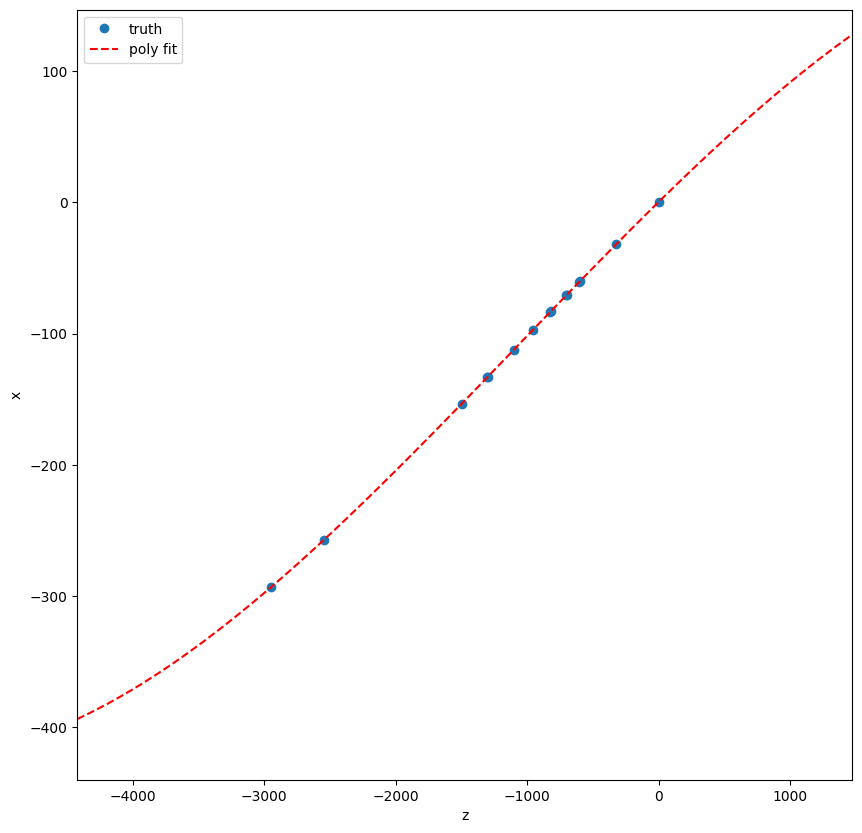

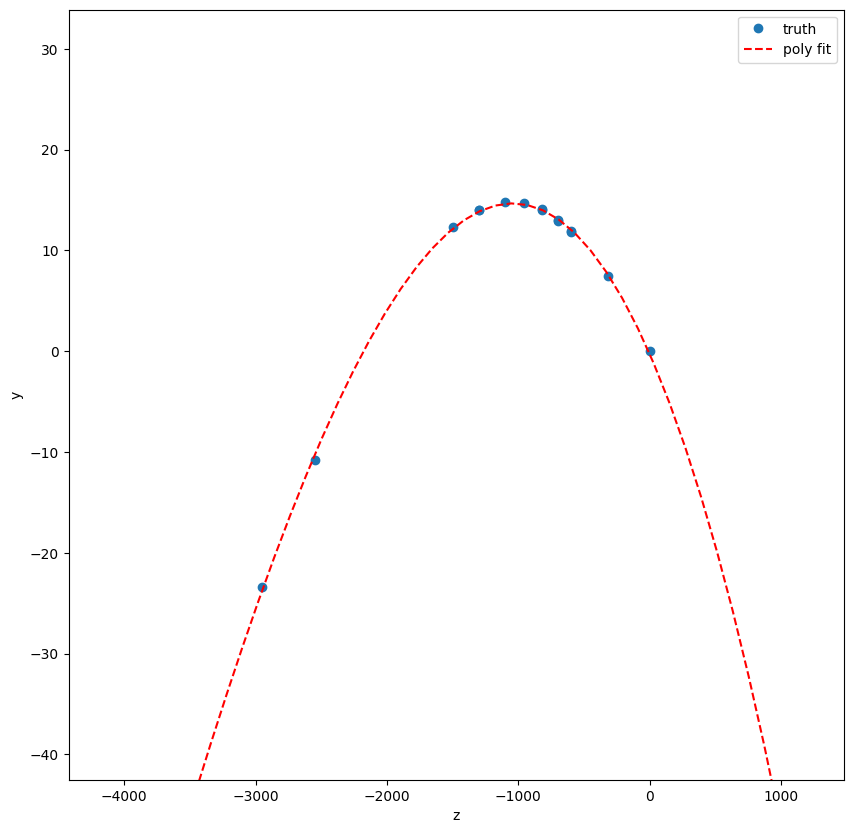

In [19]:
plot_fit(X,Y,Z, *do_fit(X,Y,Z,  deg=3), 'x', label='truth')
plot_fit(X,Y,Z, *do_fit(X,Y,Z,  deg=3), 'y', label='truth')

In [20]:
# preds = find_file(f"preds_{event_name}", dir=OUTPUT_DIR, extension="pkl")
outrunner_model_h = get_model(preload=True, save=False, dir=SOLUTION_DIR, inname="my_model_h.h5" )
module_id = get_module_id(event.hits)
used_model = outrunner_model_h

2023-08-20 02:10:17 DEBUG    Creating converter from 3 to 5


2023-08-20 02:10:18.463333: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:226] Using CUDA malloc Async allocator for GPU: 0
2023-08-20 02:10:18.463431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30935 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:02:00.0, compute capability: 7.0


In [21]:
from keras.models import Model
import numpy.typing as npt

## Get prediction

In [22]:
def get_path(
    hit_id: int,
    thr: float,
    mask: npt.NDArray,
    module_id: npt.NDArray,
    skip_same_module: bool = True,
    preds: list[npt.NDArray] | None = None,
    features: npt.NDArray | None = None,
    hits: pd.DataFrame | None = None,
    model: Model | None = None,
):
    """Predict set of hits that belong to the same track as hit_id.
    Returns list[hit_id].
    """
    # Verify correct input
    if preds is None:
        assert features is not None and hits is not None, "Either preds or features and truth must be provided"

    # Convert to index
    hit_index = hit_id - 1
    path_indices = [hit_index]
    a = 0
    while True:
        # Predict probability of each pair of hits with the last hit in the path
        hit_id_last = path_indices[-1] + 1
        if preds is not None:
            p = retrieve_predict(hit_id_last, preds)
        else:
            if features is None or hits is None or model is None:
                raise ValueError("Either preds or (features & hits & model) must be provided")

            p = make_predict(model=model, features=features, hits=hits, hit_id=hit_id_last, thr=thr)

    
        # TODO
        # p_ = p + diffs(p) * weight

        # Generate mask of hits that have a probability above the threshold
        mask = (p > thr) * mask
        # Mask last added hit
        mask[path_indices[-1]] = 0

        if skip_same_module:
            path_ids = np.array(path_indices) + 1
            mask = mask_same_module(mask, path_ids, p, thr, module_id)
            
        # TODO
        # if validator(x,y)

        # `a` is the culuminative probability between each hit in the path
        # At each step we look at the best candidate for the whole (previously geberate) track
        a = (p + a) * mask

        # Breaking condition: if best average probability is below threshold, end path
        if a.max() < thr * len(path_indices):
            break
        # Add index of hit with highest probability to path, proceed with this hit as the seed for the next iteration
        path_indices.append(a.argmax())  # type: ignore
    # Convert indices back to hit_ids by adding 1
    return np.array(path_indices) + 1

In [23]:
particle_data

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
48013,48014,720579170194685952,-293.221008,-23.41400,-2948.500,-0.203230,-0.075928,-2.32674,0.000009
49003,49004,720579170194685952,-257.315002,-10.80580,-2548.500,-0.216412,-0.070569,-2.32707,0.000008
1257,1258,720579170194685952,-153.408005,12.29760,-1498.000,-0.238495,-0.026159,-2.32681,0.000007
2673,2674,720579170194685952,-133.231995,14.02720,-1302.000,-0.240573,-0.014859,-2.32674,0.000005
2688,2689,720579170194685952,-132.819000,14.05240,-1298.000,-0.240090,-0.015046,-2.32731,0.000005
4452,4453,720579170194685952,-112.528999,14.78510,-1102.000,-0.241569,-0.002819,-2.32725,0.000005
6475,6476,720579170194685952,-97.518600,14.73110,-957.500,-0.243058,0.007250,-2.32847,0.000005
8863,8864,720579170194685952,-83.385696,14.06740,-822.000,-0.242864,0.015607,-2.32849,0.000005
8911,8912,720579170194685952,-82.916603,14.03640,-817.500,-0.242671,0.016175,-2.32903,0.000007
11338,11339,720579170194685952,-70.901001,13.01440,-702.000,-0.242123,0.024206,-2.32905,0.000008


In [24]:
particle_hit_idx = np.where(event.hits.hit_id.isin(particle_data.hit_id))[0]
particle_hit_idx 

array([ 1257,  2673,  2688,  4452,  6475,  8863,  8911, 11338, 11391,
       13805, 13841, 14128, 48013, 49003])

Test whether we got the right idx

In [25]:
event.truth.iloc[particle_hit_idx]

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
1257,1258,720579170194685952,-153.408005,12.29760,-1498.000,-0.238495,-0.026159,-2.32681,0.000007
2673,2674,720579170194685952,-133.231995,14.02720,-1302.000,-0.240573,-0.014859,-2.32674,0.000005
2688,2689,720579170194685952,-132.819000,14.05240,-1298.000,-0.240090,-0.015046,-2.32731,0.000005
4452,4453,720579170194685952,-112.528999,14.78510,-1102.000,-0.241569,-0.002819,-2.32725,0.000005
6475,6476,720579170194685952,-97.518600,14.73110,-957.500,-0.243058,0.007250,-2.32847,0.000005
8863,8864,720579170194685952,-83.385696,14.06740,-822.000,-0.242864,0.015607,-2.32849,0.000005
8911,8912,720579170194685952,-82.916603,14.03640,-817.500,-0.242671,0.016175,-2.32903,0.000007
11338,11339,720579170194685952,-70.901001,13.01440,-702.000,-0.242123,0.024206,-2.32905,0.000008
11391,11392,720579170194685952,-70.434601,12.96910,-697.500,-0.241364,0.023127,-2.32959,0.000010
13805,13806,720579170194685952,-60.558899,11.89210,-602.000,-0.240683,0.029238,-2.32964,0.000011


In [26]:
PATH_THR = 0.85
# hit_id_test = event.hits.hit_id.values[0]
# hit_id_test
hit_index_test = 0
hit_id_test = hit_index_test + 1
hit_id_test_real = event.hits.hit_id.values[hit_index_test]
hit_id_test_real, hit_id_test, hit_index_test

(1, 1, 0)

### Faux hit_id!

In [27]:
# intersection_idx = round(len(particle_hit_idx) / 2)
intersection_idx = min(9, len(particle_hit_idx) - 1)
hit_id_test = particle_hit_idx[intersection_idx] + 1
hit_id_test

13806

In [28]:
path_test_idx = get_path(hit_id_test, thr=PATH_THR, mask = np.ones(len(event.hits)), module_id=module_id,features= event.features, hits=event.hits, model=used_model) -1
path_test_idx

1/1 [==============================] - 0s 17ms/step


array([13805, 11391,  6502,  8911,  4457,  8863,  6428, 11338, 13841,
        2676,  1250, 14137, 50013, 48966, 14472])

In [29]:
path_test_idx

array([13805, 11391,  6502,  8911,  4457,  8863,  6428, 11338, 13841,
        2676,  1250, 14137, 50013, 48966, 14472])

In [30]:
path_test_data = event.hits.iloc[path_test_idx]
path_test_data

,hit_id,x,y,z,volume_id,layer_id,module_id
13805,13806,-60.553200,11.889400,-602.000000,7,14,104
11391,11392,-70.438599,12.991600,-697.500000,7,12,106
6502,6503,-97.122101,15.442700,-957.500000,7,8,106
8911,8912,-82.908096,14.023100,-817.500000,7,10,106
4457,4458,-111.817001,16.885099,-1102.000000,7,6,107
8863,8864,-83.382698,14.079300,-822.000000,7,10,104
6428,6429,-97.566597,15.479200,-962.000000,7,8,104
11338,11339,-70.906097,13.037900,-702.000000,7,12,104
13841,13842,-60.102100,11.827000,-597.500000,7,14,106
2676,2677,-132.095001,18.603100,-1302.000000,7,4,107


### Append origin and select 3 hits

In [31]:
cut_off_idx = min(2, len(path_test_data))
X_t_3, Y_t_3, Z_t_3 = path_test_data[['x', 'y', 'z']].values[:cut_off_idx].T
X_t, Y_t, Z_t = path_test_data[['x', 'y', 'z']].values.T

X_t = np.append(X_t, x_0)
Y_t = np.append(Y_t, y_0)
Z_t = np.append(Z_t, z_0)
X_t_3 = np.append(X_t_3, x_0)
Y_t_3 = np.append(Y_t_3, y_0)
Z_t_3 = np.append(Z_t_3, z_0)
X_t_3, Y_t_3, Z_t_3

(array([-60.55319977, -70.43859863,   0.        ]),
 array([11.88939953, 12.99160004,  0.        ]),
 array([-602. , -697.5,    0. ]))

## Poly fit reco

### Plot truth vs reco

<Axes: xlabel='z', ylabel='y'>

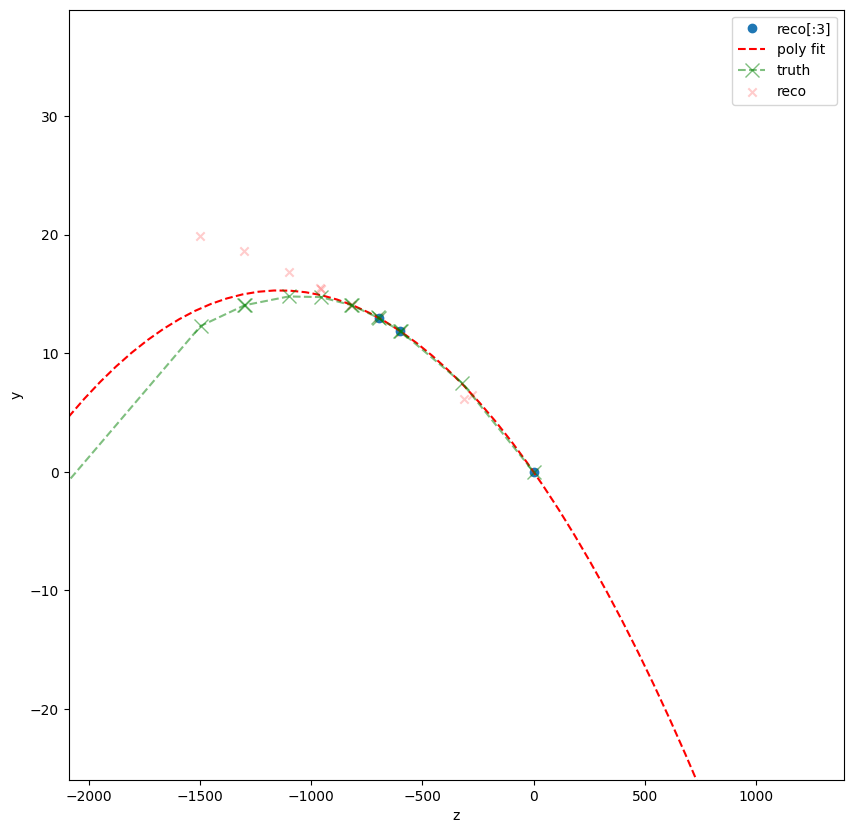

In [32]:
fig, ax = plot_fit(X_t_3,Y_t_3,Z_t_3, *do_fit(X_t_3,Y_t_3,Z_t_3, deg=2, crop=5), 'y', label='reco[:3]', crop=5)
ax.plot(Z,Y,'g--', label='truth', marker='x', markersize=10, alpha=0.5)
ax.scatter(Z_t, Y_t, color='red', marker='x',label='reco', alpha= 0.2)
ax.legend()
ax

(-307.88205871582034, 14.661050415039085) (-165.5860043525696, 156.95710477828982)


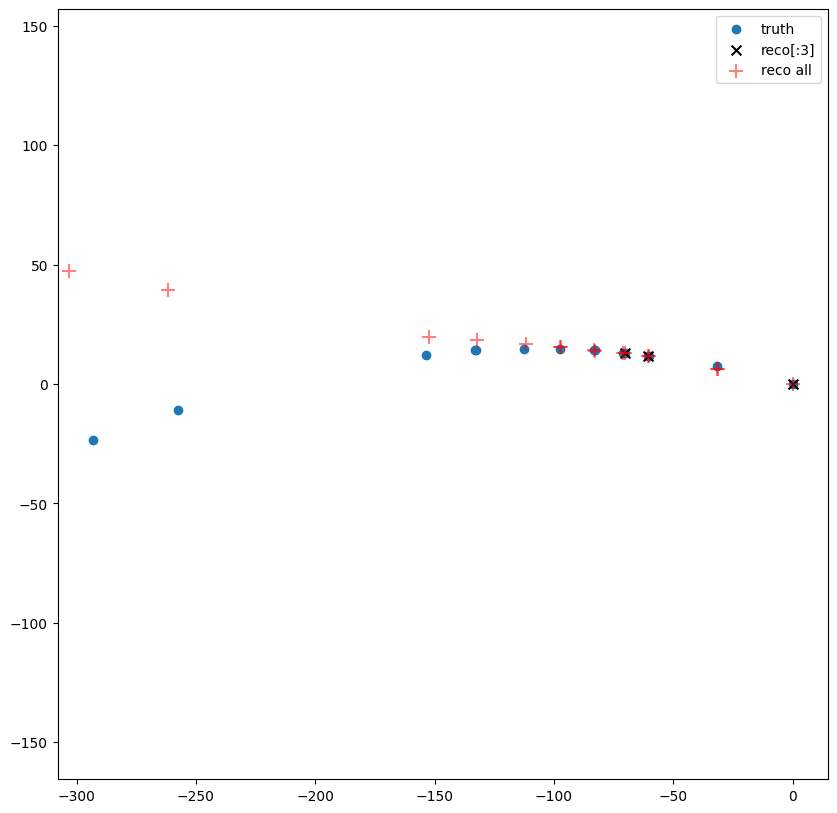

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X,Y, label='truth')
ax.scatter(X_t_3,Y_t_3, marker='x', label='reco[:3]',color='black', s=50)
ax.scatter(X_t, Y_t, color='red', marker='+',label='reco all', alpha=0.5, s=100)
ax.set_aspect('equal', 'box')

xlim, ylim = get_crop(X,Y, crop = 1.1, square = True)
print(xlim, ylim)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend()

# Circle fit $x, y$ plane

Select three hits

In [34]:
X_3 = X[[0, round(len(X)/2) - 1, -1 ]]
Y_3 = Y[[0, round(len(Y)/2) - 1, -1 ]]

### Define functions

In [35]:
from typing import Iterable
from scipy.optimize import curve_fit, minimize

def _input_to_points_xy(*args: tuple[tuple[float,float],tuple[float,float],tuple[float,float]] | tuple[tuple[float, float, float], tuple[float,float,float]] | tuple[Iterable, Iterable] | tuple[Iterable,Iterable,Iterable]) -> tuple[tuple[float, float], tuple[float, float], tuple[float, float]]:
    # Input [(x1, y1), (x2, y2), (x3, y3)]
    if len(args) == 3:
        p1, p2, p3 = args
    # Input [x1, x2, x3], [y1, y2, y3]
    elif len(args) == 2:
        X_arr, Y_arr = args
        assert len(X_arr) == len(Y_arr) == 3, "Input must be a tuple of three points or a tuple of two arrays of points."
        p1, p2, p3 = (X_arr[0], Y_arr[0]), (X_arr[1], Y_arr[1]), (X_arr[2], Y_arr[2]) # type: ignore
    else:
        raise ValueError("Input must be a tuple of three points or a tuple of two arrays of points.")
    return p1, p2, p3 # type: ignore


def define_circle(p1, p2, p3) -> tuple[tuple[float, float], float]:
    """Define a circle from three points. Returns (center_x, center_y), radius."""
    x = complex(p1[0], p1[1]) # type: ignore
    y = complex(p2[0], p2[1]) # type: ignore
    z = complex(p3[0], p3[1]) # type: ignore
    
    w = (z-x)
    w/=(y-x)
    c = (x - y) * (w - abs(w) ** 2) / 2j / w.imag - x
    r = abs(c + x)
    c1, c2 = (-c.real, -c.imag)
    return ((c1, c2), r)


def validator_circle(x: float, y: float, center: tuple[float, float], r: float, abs_tolerance = 0, rel_tolerance = 0, info: bool = False, **kwargs) -> bool | dict:
    """Validate a point against a circle."""
    dx = x - center[0]
    dy = y - center[1]
    dist = np.sqrt(dx ** 2 + dy ** 2) # distance from center of given circle
    diff = abs(dist - r) # difference between distance and radius
    validated = diff <= abs_tolerance or diff <= rel_tolerance * r ** 2
    if kwargs.get('verbose') == True:
        print("on circle:", validated, "diff", diff, r, dist )
    if not info:
        return validated
    else:
        return {
            "validated": validated,
            "diff": diff,
        }


def validator_line_xy(x: float, y: float, slope: float, intercept: float, abs_tolerance: float = 0, rel_tolerance: float = 0, info: bool = False) -> bool | dict:
    """Validate a point against a line."""
    diff = abs(y - (slope * x + intercept))
    validated = diff <= abs_tolerance or diff <= rel_tolerance * abs(y)
    if not info:
        return validated
    else:
        return {
            "validated": validated,
            "diff": diff,
        }


def get_validator_xy(*args: tuple[tuple[float,float],tuple[float,float],tuple[float,float]] | tuple[tuple[float, float, float], tuple[float,float,float]] | tuple[Iterable, Iterable] | tuple[Iterable,Iterable,Iterable], thr_collinear =  1.0e-6, **kwargs):
    """Get validation function for a track in x, y plane."""
    p1, p2, p3 = _input_to_points_xy(*args)


    # Check if points are collinear
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1]) # type: ignore
    if abs(det) < thr_collinear:
        # Since collinear, only need to check two points
        # TODO: expand to 3D
        slope, intercept = np.polyfit([p1[0], p2[0]], [p1[1], p2[1]], 1)
        print("Validator is line")
        return lambda x, y: validator_line_xy(x, y, slope, intercept, **kwargs)
    # Circle
    else:
        center, r = define_circle(p1, p2, p3)
        print("Validator is circle")
        return lambda x, y: validator_circle(x, y, center, r, **kwargs)

### 

In [36]:
# x, y =  [2,100,0],[0,1,0]
# center, r = define_cirlce(x, y)
# center, r = define_circle(*_input_to_points_xy(X_3, Y_3))
center, r = define_circle(*_input_to_points_xy(X_t_3, Y_t_3))
# _input_to_points_xy(X_3, Y_3)
# X_3, Y_3
center, r

((-113.45292669130609, -417.6757464206158), 432.8101150884085)

### Plot fits

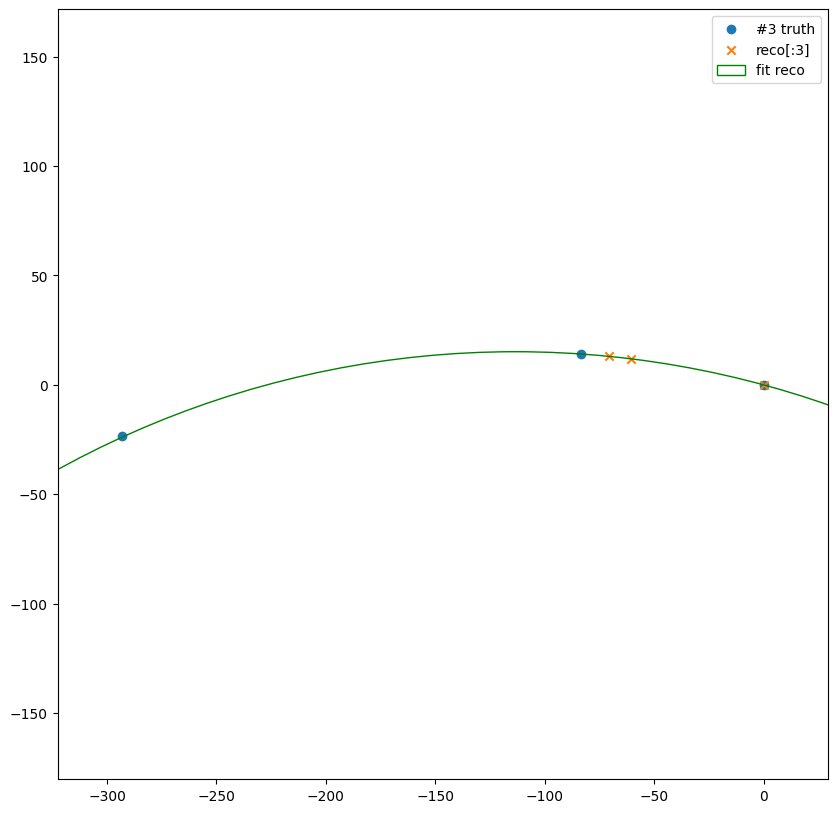

In [37]:
fig, ax = plt.subplots(figsize=(10,10))

crop = 1.2
xlim, ylim = get_crop(X, Y, crop=crop, square=True)

ax.scatter(X_3,Y_3, label='#3 truth')
ax.scatter(X_t_3,Y_t_3, marker='x', label='reco[:3]')

circle = plt.Circle(center, r, fill=False, color='g', label = 'fit reco')
ax.add_patch(circle)

ax.set_aspect('equal', 'box')
ax.set(xlim=xlim, ylim=ylim)
ax.legend()

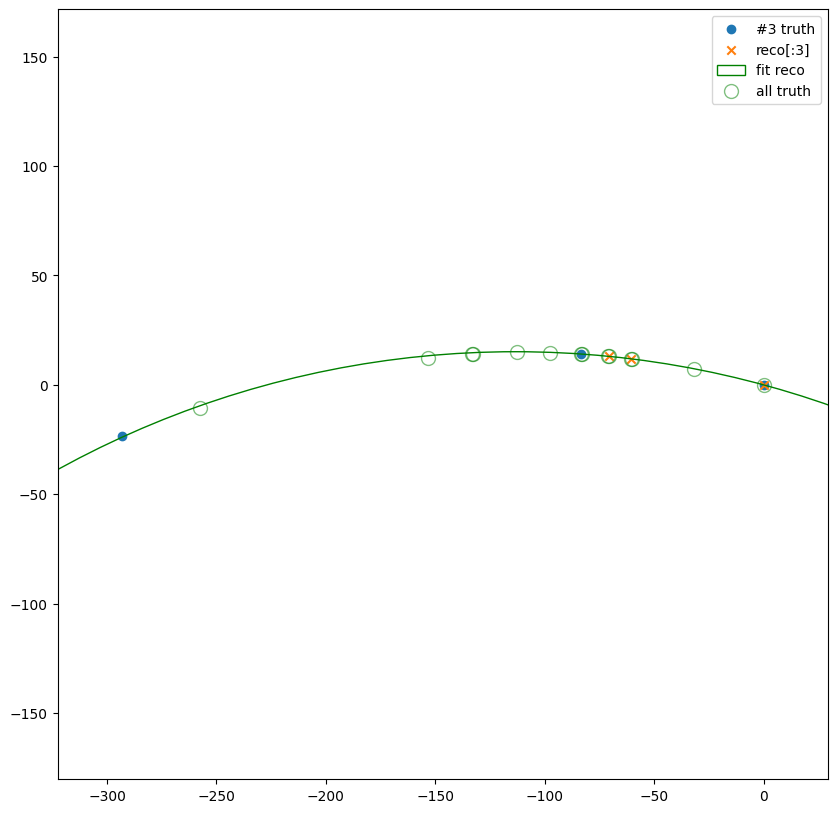

In [38]:
ax.plot(X[1:],Y[1:],'o', color='green', fillstyle='none', alpha=0.5, label = 'all truth', markersize=10)
ax.legend()
fig

In [39]:
# ax.scatter(X_t, Y_t)
# fig

Test circle fit with truth data

In [40]:
validator_xy = get_validator_xy(X_t_3,Y_t_3, abs_tolerance=5)
# print(X, Y, Z)

for x, y in zip(X,Y):
    validator_xy(x, y)

Validator is circle


In [41]:
allowed = np.array([validator_xy(x, y) for x, y in zip(X_t,Y_t)])

In [42]:
allowed

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False, False,  True,  True])

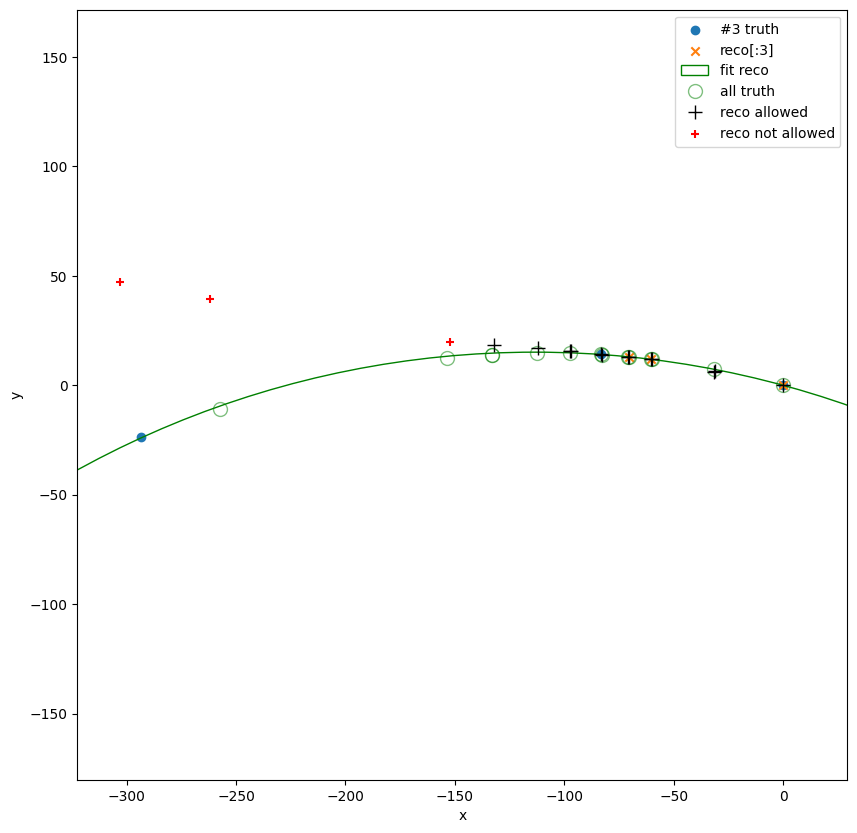

In [43]:
ax.plot(X_t[allowed], Y_t[allowed], color='black', marker='+', markersize=10, label='reco allowed', linestyle='None')
ax.scatter(X_t[~allowed], Y_t[~allowed], color='red', marker='+', label='reco not allowed')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
fig

# Sine fit $x, z$ and $y, z$ planes

If circle is defined by: $ (x-c_x)^2 + (y-c_y)^2 = R^2$

let: 

$
\begin{equation}
y(z) = c_y + R \cdot \sin[f(z - z_0) + \phi_0]
\end{equation} \\
\begin{equation}
x(z) = c_x + R \cdot \cos[f(z - z_0) + \phi_0]
\end{equation}
$

We assume 

$
\begin{equation}
y(z_0) = 0  \\
\therefore \phi_0 =  \arcsin{-\frac{c_y}{R}}
\end{equation}
$

Similarly 
$
\begin{equation}
x(z_0) = 0 \therefore \phi_0 =  \arcsin{-\frac{c_y}{R}} = \arccos{-\frac{c_x}{R}}
\end{equation}
$

We are only missing $f$ in equations (1)

In [44]:
def trig(x, A, B, f, phi_0, z_0, intercept):
    if A == 0:
        return B * np.cos(f * (x + z_0) + phi_0) + intercept 
    if B == 0:
        return A * np.sin(f * (x + z_0) + phi_0) + intercept

    _sin = np.sin(f * (x + z_0) + phi_0)
    _cos = np.cos(f * (x + z_0) + phi_0)
    return A * _sin + B * _cos + intercept

## Plot xz, yz planes

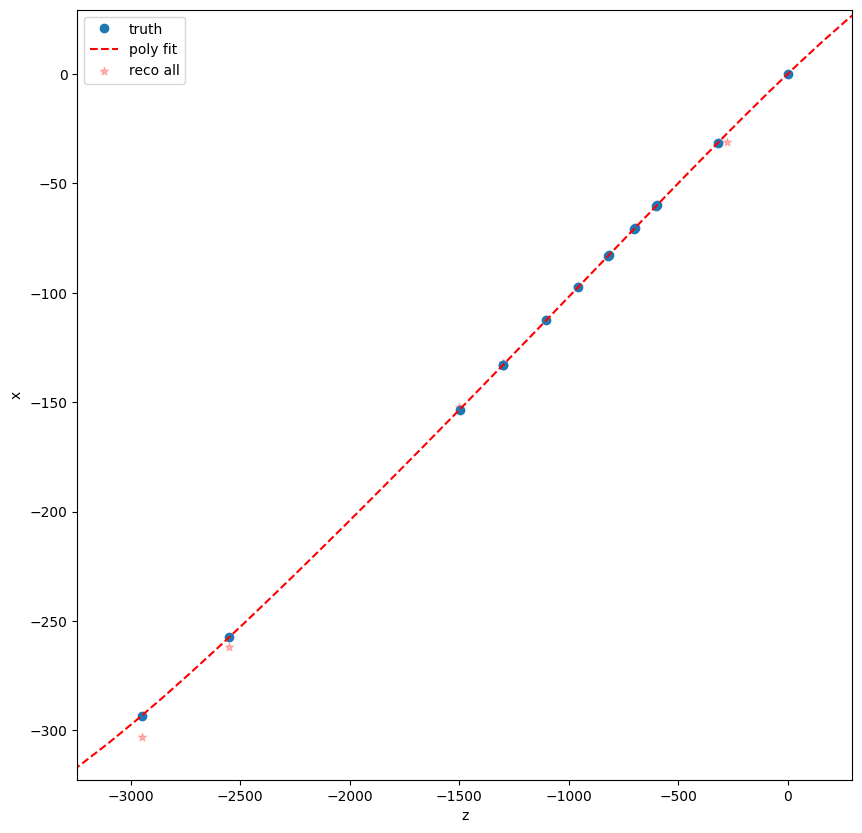

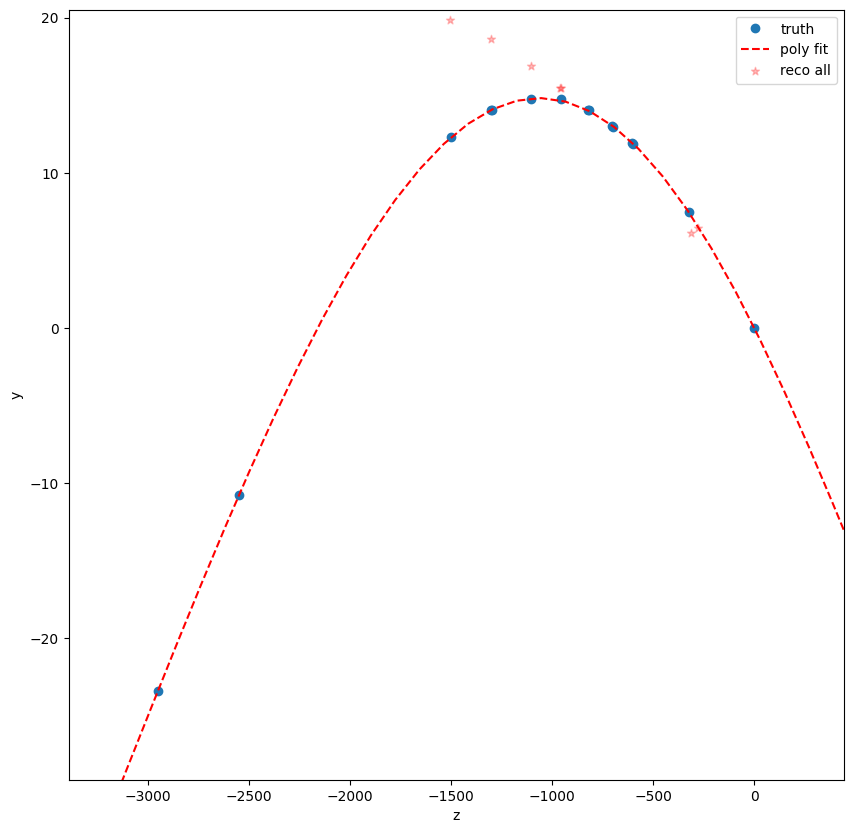

In [45]:
fig_zx, ax_zx = plot_fit(X,Y,Z, *do_fit(X,Y,Z,  deg=5), 'x',crop=1.2, label ='truth')
fig_zy, ax_zy = plot_fit(X,Y,Z, *do_fit(X,Y,Z,  deg=5), 'y',crop=1.3, label='truth')
ax_zx.scatter(Z_t, X_t, color='red', marker='*',label='reco all', alpha=0.25)
ax_zy.scatter(Z_t, Y_t, color='red', marker='*',label='reco all', alpha=0.25)
ax_zx.legend()
ax_zy.legend()

-417.6757464206158


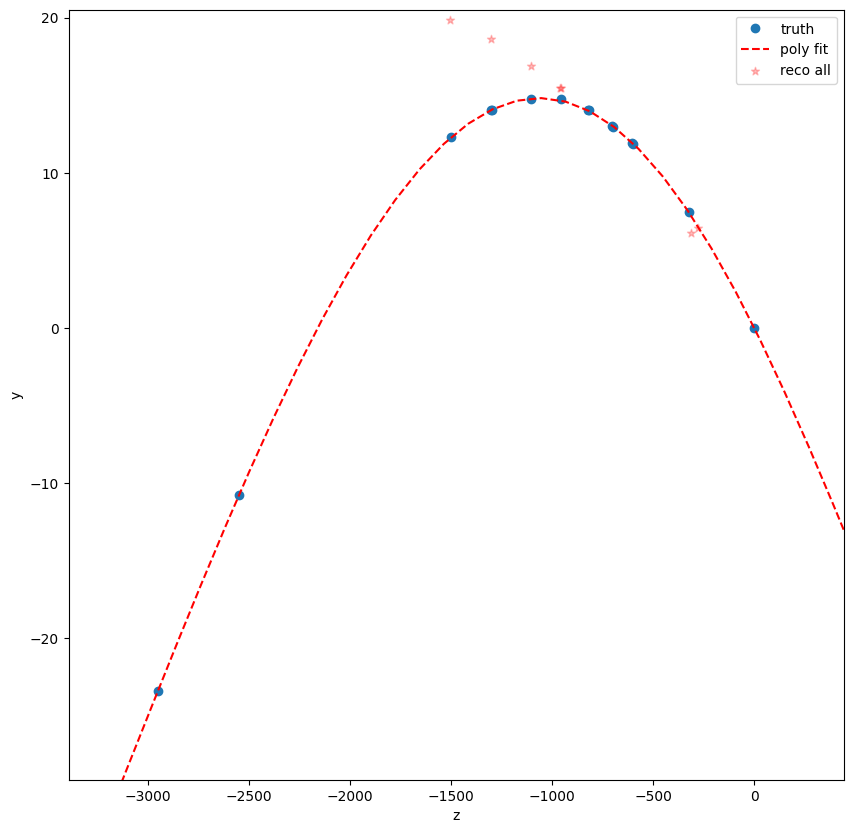

In [46]:
# Use that it passes through origin, so R * sin(f * x + phi) = -y0 |x=0
center_x, center_y = center
print(center_y)
ax_zy.plot([-3000, 1000], [center_y, center_y], color="black", linestyle="dashed")
fig_zy

## Calculate $\phi_0$

In [47]:
center

(-113.45292669130609, -417.6757464206158)

In [48]:
# _center_x, _center_y = center
import math
_r = 1
_theta = np.pi/4
_center_x, _center_y = _r * np.cos(_theta), _r * np.sin(_theta)
print('truth',( _theta + 2 * np.pi % (2 * math.pi)) - np.pi)

truth -2.356194490192345


In [49]:
(_center_x, _center_y), _r = center, r
print('atan', (math.atan2(_center_y, _center_x) + np.pi) %(2*np.pi))
print('atan2', math.atan2(-_center_y, -_center_x))
phi_0_x = np.arccos(-_center_x/_r )
phi_0_y = np.arcsin(-_center_y/_r )
if center_x > 0:
    phi_0_y += np.pi
if center_y < 0:
    phi_0_x *= -1
phi_0 = (phi_0_y + phi_0_x)/2
print("phi_0_x: ", phi_0_x)
print("phi_0_y: ", phi_0_y)
print("diff: ", phi_0_x - phi_0_y )
print("diff - pi: ", abs(phi_0_x - phi_0_y) - np.pi )
print("%: ", 100* (phi_0_x - phi_0_y)/phi_0)
print("phi_0: ", phi_0, "radians", phi_0/np.pi, "pi's")

atan 1.3055666193980557
atan2 1.3055666193980557
phi_0_x:  -1.3055666193980557
phi_0_y:  1.305566619398056
diff:  -2.6111332387961115
diff - pi:  -0.5304594147936816
%:  -2.3518997362513766e+18
phi_0:  1.1102230246251565e-16 radians 3.533949646070574e-17 pi's


In [50]:
def get_phi_0(center, r, single=True):
    # phi_0_y = np.arcsin(-center_y / r)
    # if single:
    #     return phi_0_y
    # phi_0_x = np.arccos(-center_x / r)
    # phi_0 = (phi_0_y + phi_0_x)/2
    # # TODO: test for diff phi_0
    return math.atan2(-_center_y, -_center_x)

In [51]:
phi_0 = get_phi_0(center, r)
phi_0

1.3055666193980557

## Estimate $f$

for each point in the reco list $p_i \in \set{p1, p2, p3, ...}$ that should be on the helix

where a point $p_i$ defines the coordinate
$\begin{bmatrix} 
x \\
y \\
z
\end{bmatrix}$

assuming the helix also passes through 
$p_0 = 
\begin{bmatrix} 
0 \\
0 \\
z_0
\end{bmatrix}$

we can use $p_x = x(p_z) = c_x + R \cdot \cos[f(p_z - z_0) + \phi_0]$
to get

$
\begin{equation}
f = \frac{\arccos{\frac{p_x-c_x}{R}-\phi_0}}{p_z - z_0}
\end{equation}
$

and similarly $p_y = y(p_z) = c_y + R \cdot \sin[f(p_z - z_0) + \phi_0]$

$ 
\begin{equation}
\therefore
f = \frac{\arcsin{\frac{p_y-c_y}{R}-\phi_0}}{p_z - z_0}
\end{equation}
$

In [52]:
p1 = (X_t_3[0], Y_t_3[0], Z_t_3[0])
a, b, c = p1
_f_y = (np.arcsin((b-center_y)/r) - phi_0) / (c - 0)
1/_f_y

-4218.656361345081

In [53]:
p1 = (X_t_3[0], Y_t_3[0], Z_t_3[0])
a, b, c = p1
_f_x = (np.arccos((a-center_x)/r) - phi_0) / (c - 0)
1/_f_x, _f_x

(-4218.656361345081, -0.0002370422983874323)

In [54]:
print("Diff", _f_x - _f_y)
print("Rel", 2 * (_f_x - _f_y)/ (_f_x + _f_y))

Diff 0.0
Rel -0.0


In [55]:
phi_0 = math.atan2(-_center_y, -_center_x)
f_z = (math.atan2(b-center_y, a-center_x) - phi_0)/(c-0)
1/f_z

-4218.656361345081

In [56]:
def get_f(x: float, y: float, z: float, center: tuple[float, float], r: float, phi_0: float, z_0: float, single = True):
    """Get frequency f of helix passing through point (x, y, z) and (0, 0, z_0) with parameters `center`, `r`, `phi_0` and `z_0`."""

    assert z != z_0, "z and z_0 must be different"
    
    center_x, center_y = center
    # f_x = (np.arccos((x - center_x) / r) - phi_0) / (z - z_0)

    # if single:
    #     return f_x
    # f_y = (np.arcsin((y - center_y) / r) - phi_0) / (z - z_0)
    
    # f = (f_x + f_y) / 2

    # return f

    return (math.atan2(y - center_y, x - center_x) - phi_0) / (z - z_0)

In [57]:
f_cand = []
for p in zip(X_t_3, Y_t_3, Z_t_3):
    a, b, c = p
    if c == z_0:
        continue
    f_cand.append(get_f(a, b, c, center, r, phi_0, z_0))
_f = sum(f_cand)/len(f_cand)
diffs = [2 * abs(_f - f_) for f_ in f_cand]
print("Diff: ", sum(diffs))
print("Rel: ", sum(diffs)/_f)

Diff:  9.879149544303988e-07
Rel:  -0.004163335850636236


In [58]:
def get_f_all(x_arr: Iterable[float], y_arr: Iterable[float], z_arr: Iterable[float], center: tuple[float, float], r: float, phi_0: float, z_0: float, single = True):
    f_cand = []
    for x, y, z in zip(x_arr, y_arr, z_arr):
        if z == z_0:
            continue
        print(x, y, z)
        print(get_f(x, y, z, center, r, phi_0, z_0, single))
        f_cand.append(get_f(x, y, z, center, r, phi_0, z_0, single))
    f = sum(f_cand) / len(f_cand)
    return f

In [59]:
f = get_f_all(X_t_3, Y_t_3, Z_t_3, center, r, phi_0, z_0)
1/f

-60.553199768066406 11.889399528503418 -602.0
-0.0002370422983874323
-70.4385986328125 12.991600036621094 -697.5
-0.0002375362558646475


-4214.265440527405

### Plot corresponding $\sin$, $\cos$ funcs

(-23.413999557495117, 47.17409896850586)


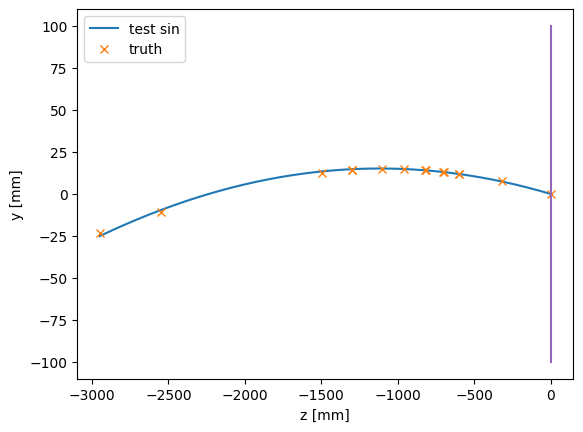

In [60]:
z_range = min(min(Z), min(Z_t)), max(max(Z), (max(Z_t)))
y_range = min(min(Y), min(Y_t)), max(max(Y), (max(Y_t)))
print(y_range)
z_in = np.linspace(*z_range, 1000)
plt.plot(z_in, r*np.sin(phi_0 + f*z_in) + center_y, label="test sin")
plt.plot(Z,Y,'x', label='truth')
plt.xlabel('z [mm]')
plt.ylabel('y [mm]')
plt.plot(*z_range,[0,0])
plt.plot([0,0],[-100,100])
plt.legend()
# plt.ylim(*y_range)
# r*np.sin(phi_0_2 + 0) + center_y

In [61]:
y_z = r*np.sin(phi_0 + z_in *f) + center_y
y_z

array([-25.06708427, -24.93960374, -24.81231584, -24.68522063,
       -24.55831818, -24.43160854, -24.30509179, -24.17876799,
       -24.05263718, -23.92669945, -23.80095484, -23.67540343,
       -23.55004526, -23.42488041, -23.29990893, -23.17513089,
       -23.05054635, -22.92615537, -22.80195801, -22.67795432,
       -22.55414438, -22.43052824, -22.30710596, -22.18387761,
       -22.06084324, -21.93800291, -21.81535669, -21.69290463,
       -21.57064679, -21.44858325, -21.32671404, -21.20503924,
       -21.0835589 , -20.96227309, -20.84118186, -20.72028527,
       -20.59958338, -20.47907625, -20.35876395, -20.23864652,
       -20.11872403, -19.99899653, -19.87946409, -19.76012677,
       -19.64098462, -19.52203769, -19.40328606, -19.28472978,
       -19.1663689 , -19.04820348, -18.93023359, -18.81245927,
       -18.6948806 , -18.57749761, -18.46031038, -18.34331897,
       -18.22652341, -18.10992378, -17.99352014, -17.87731253,
       -17.76130102, -17.64548566, -17.52986651, -17.41

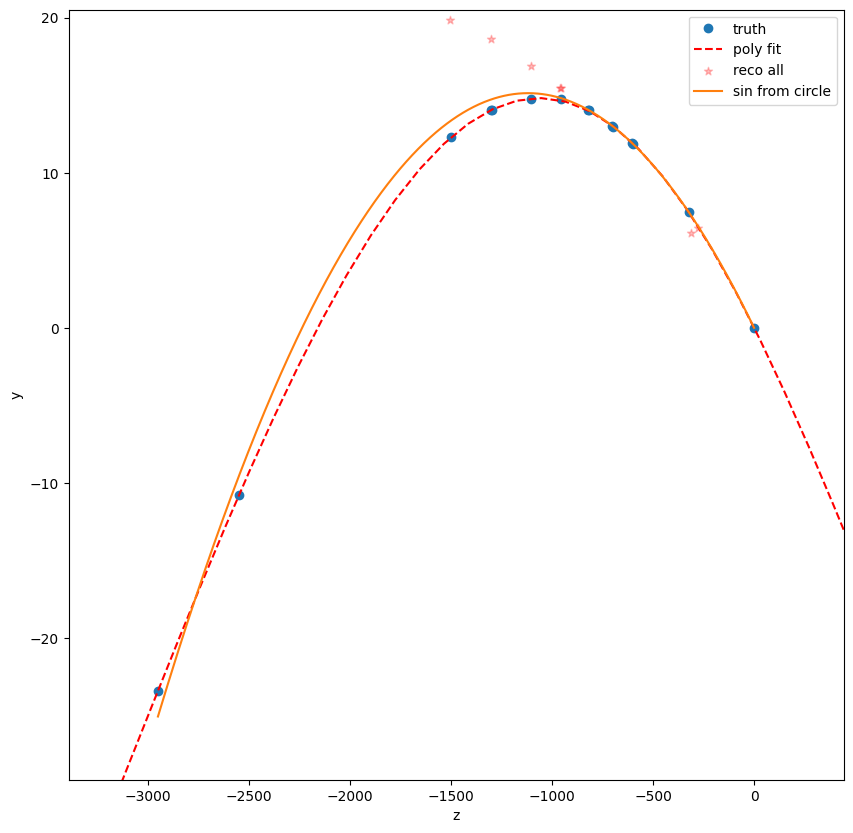

In [62]:
ax_zy.plot(z_in, y_z, label="sin from circle")
ax_zy.legend()
fig_zy

In [63]:
x_z = r*np.cos(phi_0 + z_in *f) + center_x
x_z

array([-2.95615036e+02, -2.95340029e+02, -2.95064932e+02, -2.94789747e+02,
       -2.94514472e+02, -2.94239109e+02, -2.93963657e+02, -2.93688117e+02,
       -2.93412488e+02, -2.93136771e+02, -2.92860965e+02, -2.92585072e+02,
       -2.92309091e+02, -2.92033022e+02, -2.91756865e+02, -2.91480621e+02,
       -2.91204290e+02, -2.90927872e+02, -2.90651366e+02, -2.90374774e+02,
       -2.90098095e+02, -2.89821329e+02, -2.89544476e+02, -2.89267538e+02,
       -2.88990513e+02, -2.88713402e+02, -2.88436205e+02, -2.88158922e+02,
       -2.87881553e+02, -2.87604099e+02, -2.87326560e+02, -2.87048935e+02,
       -2.86771225e+02, -2.86493430e+02, -2.86215550e+02, -2.85937586e+02,
       -2.85659537e+02, -2.85381403e+02, -2.85103185e+02, -2.84824883e+02,
       -2.84546497e+02, -2.84268026e+02, -2.83989473e+02, -2.83710835e+02,
       -2.83432114e+02, -2.83153310e+02, -2.82874422e+02, -2.82595451e+02,
       -2.82316397e+02, -2.82037261e+02, -2.81758042e+02, -2.81478740e+02,
       -2.81199356e+02, -

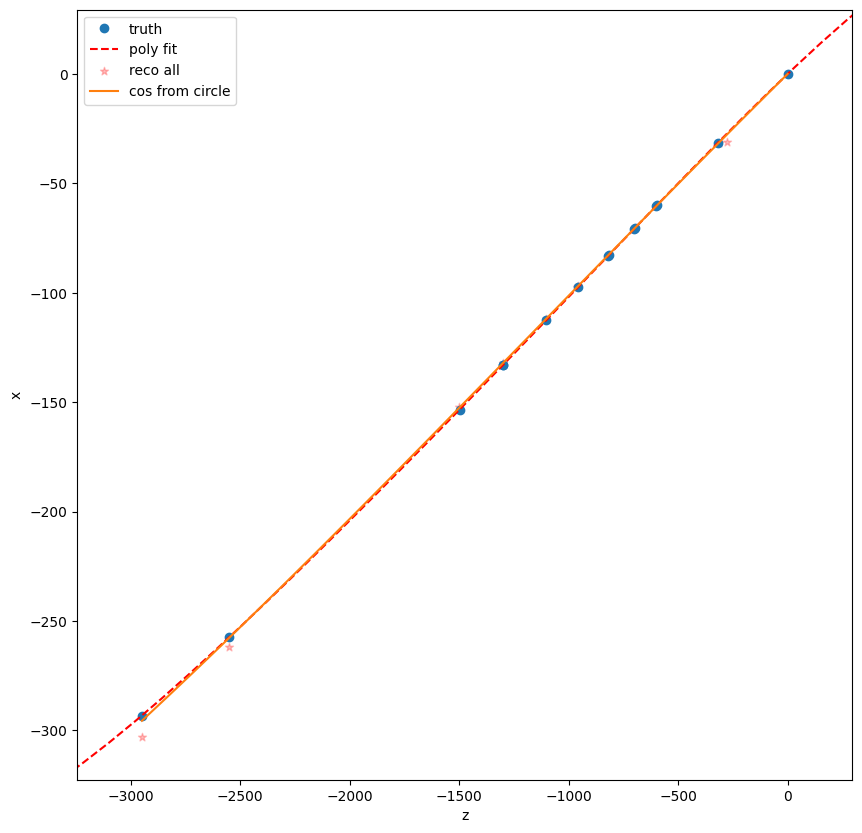

In [64]:
ax_zx.plot(z_in, x_z, label="cos from circle")
ax_zx.legend()
fig_zx

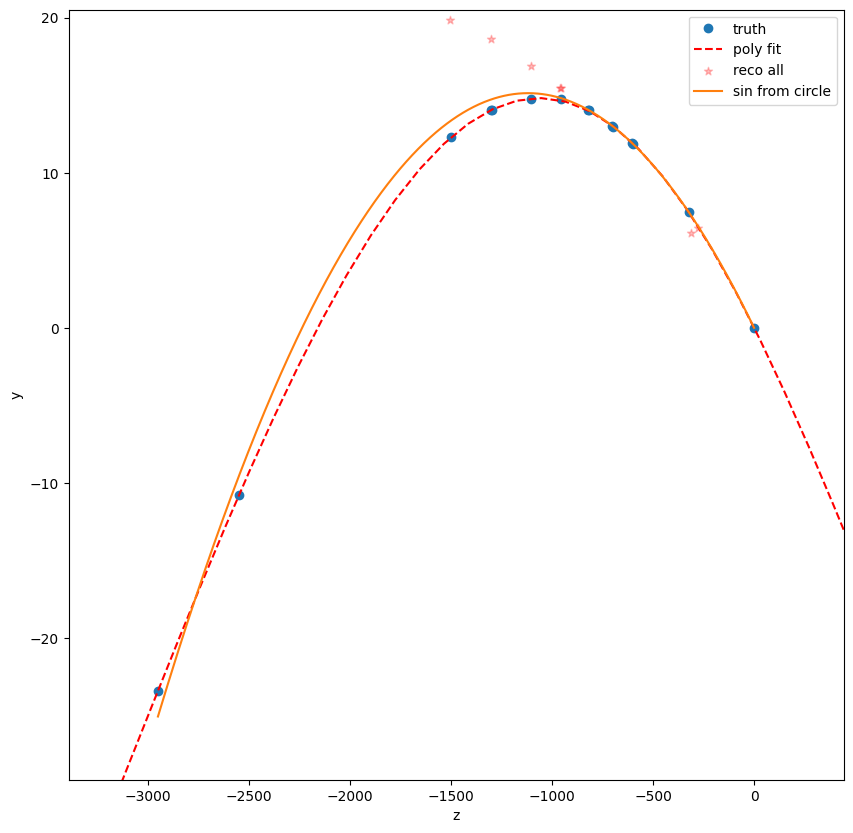

In [65]:
fig_zy

## Curve fit $f$

In [66]:
z_0, 1/f, r, phi_0

(0, -4214.265440527405, 432.8101150884085, 1.3055666193980557)

In [67]:
sin_test = lambda x, f: trig(x, r, 0, f, phi_0, z_0, center_y)
curve_fit(sin_test, Z_t_3, Y_t_3, p0=(1/4000) )

(array([-0.00023728]), array([[3.03886328e-14]]))

In [68]:
from scipy.optimize import curve_fit

z_0=0
# phi_0 = np.arcsin(-center_y/r ) 
# sin_test = lambda x, f, phi_0: trig(x, r, 0, f, phi_0, z_0, center_y)
# cos_test = lambda x, f, phi_0: trig(x, 0, r, f, phi_0, z_0, center_x)
sin_test = lambda x, f: trig(x, r, 0, f, phi_0, z_0, center_y)
cos_test = lambda x, f: trig(x, 0, r, f, phi_0, z_0, center_x)

# popt_zy, pcov = curve_fit(sin_test, Z[4:], Y[4:], p0=(1/4000,np.arcsin(- center_y / r)) )
# popt_zy, pcov = curve_fit(sin_test, Z[4:], Y[4:], p0=(1/4000) )
popt_zy, pcov = curve_fit(sin_test, Z_t_3, Y_t_3, p0=(1/4000) )
popt_zx, pcov = curve_fit(cos_test, Z_t_3, X_t_3, p0=(1/4000) )

# popt_zy, pcov = curve_fit(sin_test, Z, Y, p0=((1/4000),0))
# f, phi_0, z_0 = popt
fitted_func_zy = lambda x_arr: [sin_test(x, *popt_zy) for x in x_arr]
fitted_func_zx = lambda x_arr: [cos_test(x, *popt_zx) for x in x_arr]
1/popt_zx[0], 1/popt_zy[0]

(-4213.61341908858, -4214.516953024063)

In [69]:
f_zy  = popt_zy
f_zx  = popt_zx
f = np.mean([f_zy, f_zx])
1/f

-4214.065137624846

### Plot $z, y$

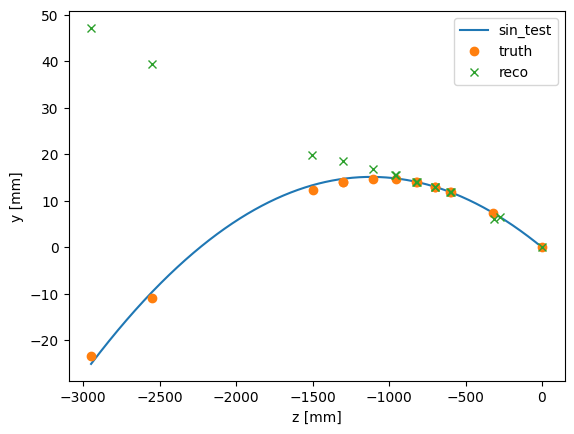

In [70]:
# Z, Y
# plt.plot(z_in, [ sin_test(x, f) for x in z_in], label='sin_test')
plt.plot(z_in, [ sin_test(x, f_zx) for x in z_in], label='sin_test')
plt.plot(Z, Y, 'o', label='truth')
plt.plot(Z_t, Y_t, 'x', label='reco')
plt.xlabel('z [mm]')
plt.ylabel('y [mm]')
plt.legend()

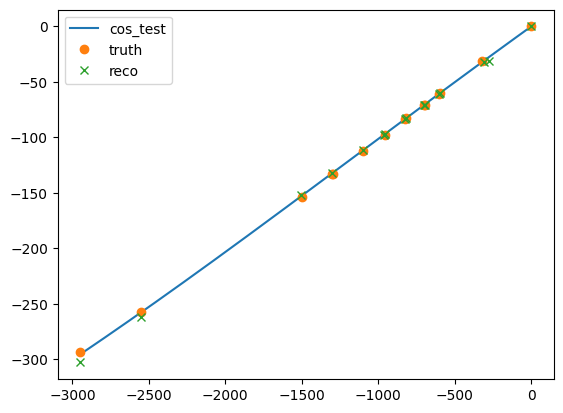

In [71]:
# Z, X
plt.plot(z_in, [ cos_test(x, f) for x in z_in], label='cos_test') 
plt.plot(Z, X, 'o', label='truth')
plt.plot(Z_t, X_t, 'x', label='reco')
plt.legend()

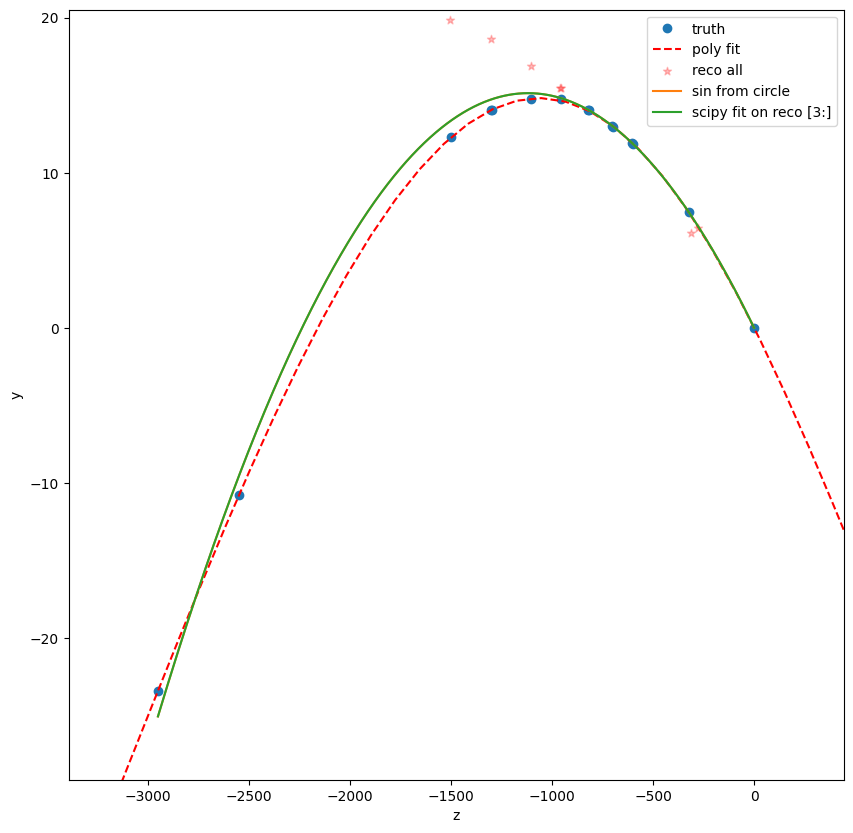

In [72]:
# ax_zy.plot(z_in, fitted_func(z_in), label='scipy fit on truth [:4]')
ax_zy.plot(z_in, fitted_func_zy(z_in), label='scipy fit on reco [3:]')
ax_zy.legend()
fig_zy

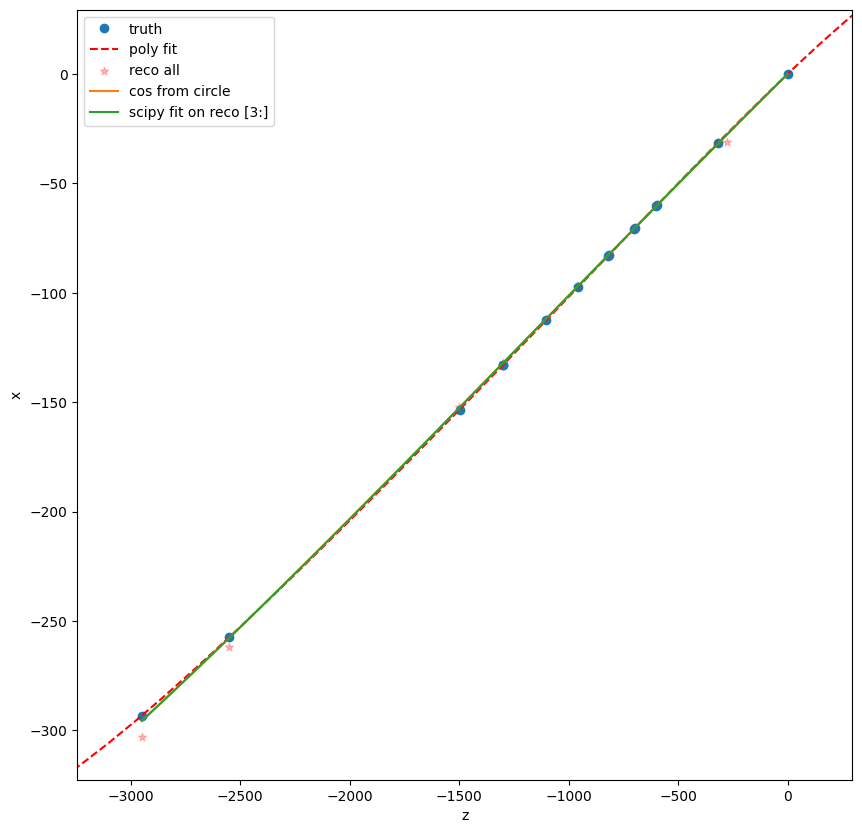

In [73]:
ax_zx.plot(z_in, fitted_func_zx(z_in), label='scipy fit on reco [3:]')
ax_zx.legend()
fig_zx

fit on right 4 hits of truth

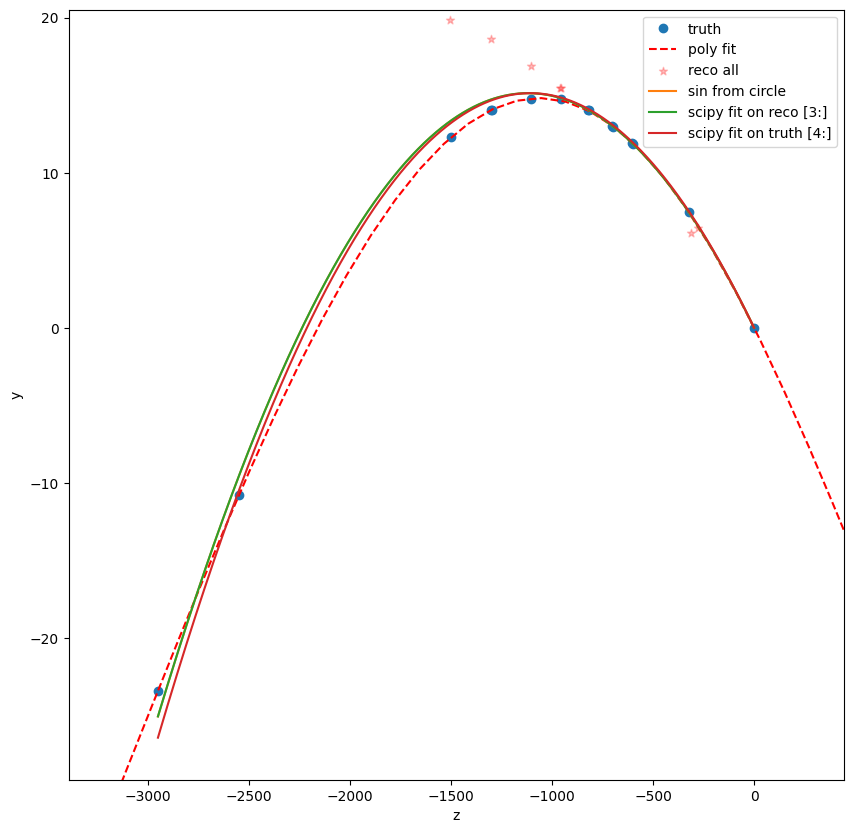

In [74]:
popt_zy, pcov = curve_fit(sin_test, Z[4:], Y[4:], p0=(1/4000) )
fitted_func_zy = lambda x_arr: [sin_test(x, *popt_zy) for x in x_arr]

ax_zy.plot(z_in, fitted_func_zy(z_in), label='scipy fit on truth [4:]')

ax_zy.legend()
fig_zy

Fit on left 4 hits of truth

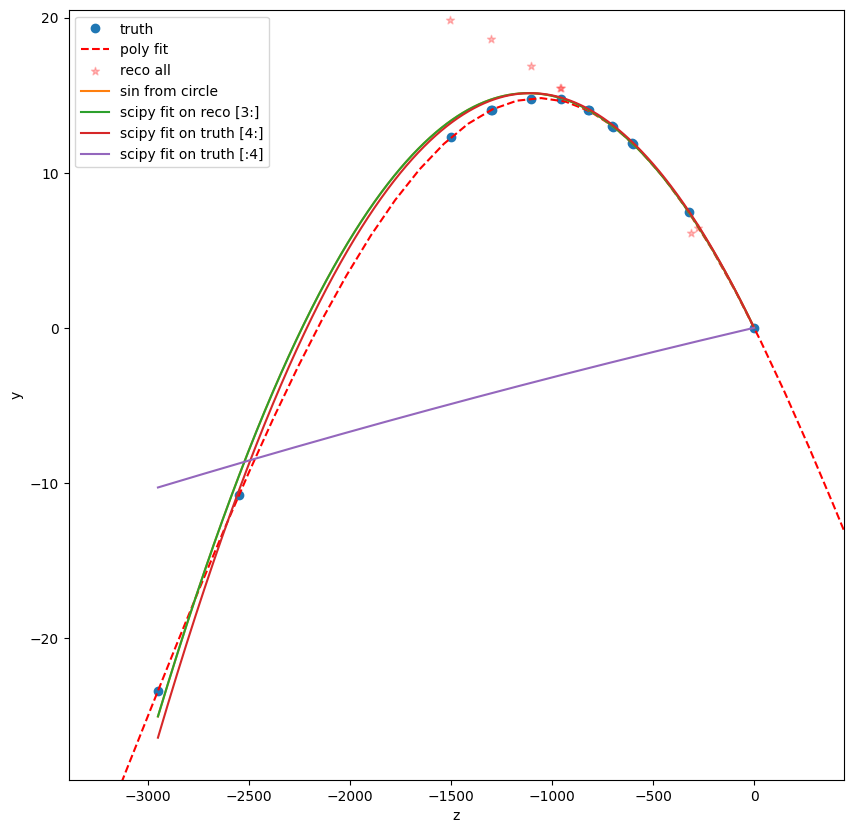

In [75]:
popt_zy, pcov = curve_fit(sin_test, Z[:4], Y[:4], p0=(1/4000) )
fitted_func_zy = lambda x_arr: [sin_test(x, *popt_zy) for x in x_arr]

ax_zy.plot(z_in, fitted_func_zy(z_in), label='scipy fit on truth [:4]')

ax_zy.legend()
fig_zy

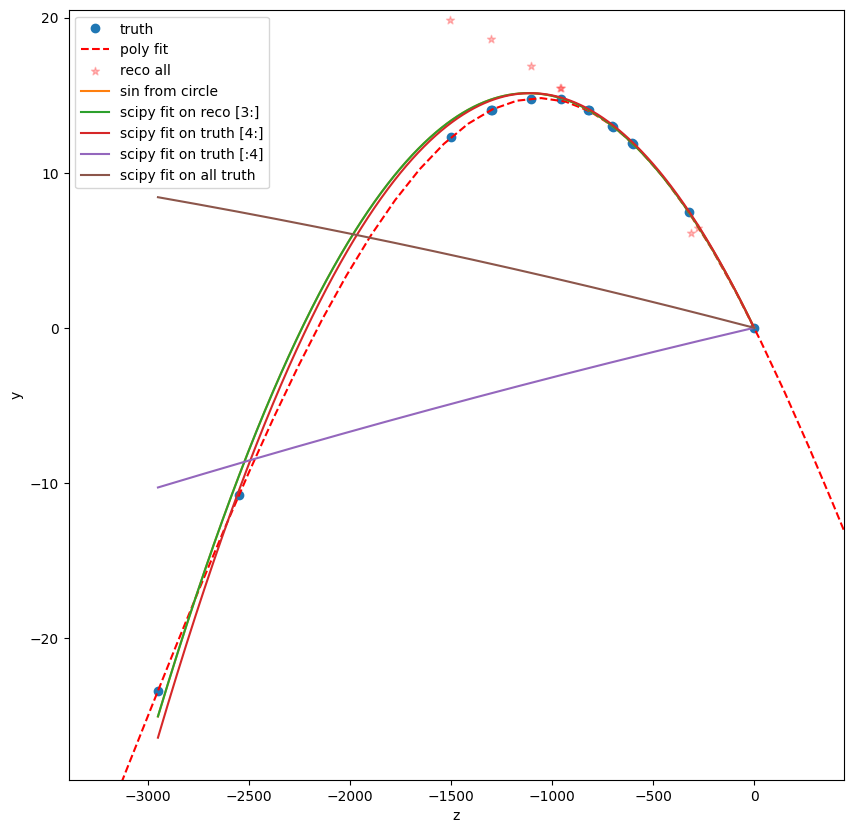

In [76]:
# popt_zy, pcov = curve_fit(sin_test, Z, Y, p0=(1/4000,np.arcsin(- center_y / r)) )
popt_zy, pcov = curve_fit(sin_test, Z, Y, p0=(1/4000) )
# f, phi_0 = popt_zy
f = popt_zy
fitted_func_zy = lambda x_arr: [sin_test(x, *popt_zy) for x in x_arr]

ax_zy.plot(z_in, fitted_func_zy(z_in), label='scipy fit on all truth')

ax_zy.legend()
fig_zy

### Plot $z, x$

In [77]:
# combined = lambda: x, fcos_test()
# popt_zx, pcov = curve_fit(cos_test, Z, X, p0=(1/4000,np.arccos(- center_x / r)) )
popt_zx, pcov = curve_fit(cos_test, Z, X, p0=(1/4000) )

In [78]:
popt_zy, popt_zx # f, phi

(array([-3.01525695e-05]), array([-0.00023711]))

In [79]:
fitted_func_zx = lambda x_arr: [cos_test(x, *popt_zx) for x in x_arr]

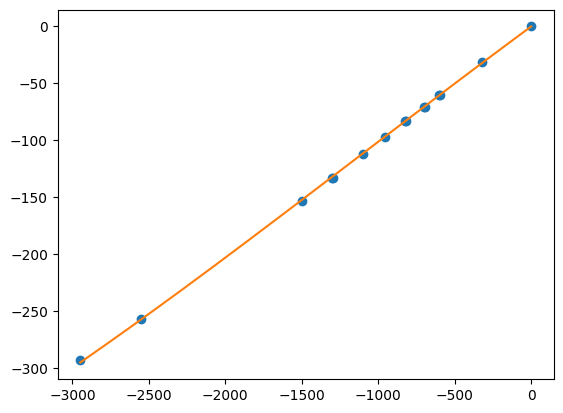

In [80]:
# plt.plot(z_in, fitted_func_zx(z_in), label='scipy fit on all truth')


plt.plot(Z,X, 'o',label='truth')
# plt.plot(z_in, r*np.cos(phi_0 + z_in *f) + center_x
plt.plot(z_in, fitted_func_zx(z_in), label='scipy fit on all truth')

# Global validator

## Define functions

In [81]:
def are_collinear(point1, point2, point3, threshold =  1.0e-6):
    assert len(point1) == len(point2) == len(point3) == 3, "Points must be in 3D space."

    # Create vectors from point1 to point2 and from point1 to point3
    vector1 = np.array(point2) - np.array(point1)
    vector2 = np.array(point3) - np.array(point1)

    # Compute the cross product of the vectors
    cross_product = np.cross(vector1, vector2)

    # Check if the cross product is the zero vector
    return np.linalg.norm(cross_product) < threshold

def line_equation(p1: tuple[float, float, float], p2: tuple[float, float, float]):
    """Get line equation from two points in 3D space.
    Returns 
    """
    x1, y1, z1 = p1
    x2, y2, z2 = p2

    # Define line equation intercept + z * slope
    x = lambda z: x1 + (z - z1) * ((x2 - x1) / (z2 - z1))
    y = lambda z: y1 + (z - z1) * ((y2 - y1) / (z2 - z1))

    return x, y


def validator_line(x: float, y: float, z: float, p1: tuple[float, float, float],  p2: tuple[float, float, float], abs_tolerance_line: float = 0, rel_tolerance: float = 0, info: bool = False, **kwargs) -> bool | dict:
    """Validate a point against a line in 3D space passing through `p1` and `p2`."""
    # Get equation in 3D space passing through p1 and p2
    x_eq, y_eq = line_equation(p1, p2)

    distance = lambda z: np.sqrt((x_eq(z) - x) ** 2 + (y_eq(z) - y) ** 2 + (z - z) ** 2)
    result = minimize(distance, x0=z)
    min_dist = result.fun
    z_min = result.x[0]

    validated = min_dist <= abs_tolerance_line # ignores rel tolerance

    if not info:
        return validated
    else:
        return {
            "validated": validated,
            "diff": min_dist,
            "z_min": z_min,
            "eq_yz": y_eq,
            "eq_xz": x_eq,
        }
        

def validator_trig(x: float, y: float, z: float, center: tuple[float, float], r: float, f: float, phi_0: float, z_0: float, abs_tolerance = 0, rel_tolerance = 0, info: bool = False) -> bool | dict:
    """Validate against a sin and cos function."""
    # Define test functions
    center_x, center_y = center
    sin_test = lambda x: trig(x, r, 0, f, phi_0, z_0, center_y) # yz plane
    cos_test = lambda x: trig(x, 0, r, f, phi_0, z_0, center_x) # xz plane
    
    # Test sin in yz plane
    distance_sin = lambda z_t: np.sqrt((z_t - z) ** 2 + (sin_test(z_t) - y) ** 2)
    # Test cos in xz plane
    distance_cos = lambda z_t: np.sqrt((z_t - z) ** 2 + (cos_test(z_t) - x) ** 2)

    # Minimize functions to get distance
    result_yz = minimize(distance_sin, x0=z)
    result_xz = minimize(distance_cos, x0=z)

    # Get distance
    dist_yz = result_yz.fun
    dist_xz = result_xz.fun

    # Get z value of minimum
    z_min_yz = result_yz.x[0]
    z_min_xz = result_xz.x[0]
    z_min = (z_min_yz + z_min_xz) / 2

    # Get distance from z_min
    dist_z = abs(z - z_min)
    dist_x = abs(x - cos_test(z_min))
    dist_y = abs(y - sin_test(z_min))
    dist_xyz = np.sqrt(dist_x ** 2 + dist_y ** 2 + dist_z ** 2)
    

    validated_yz = dist_yz <= abs_tolerance or dist_yz <= rel_tolerance * r ** 2
    validated_xz = dist_xz <= abs_tolerance or dist_xz <= rel_tolerance * r ** 2
    validated_xyz = dist_xyz <= abs_tolerance or dist_xyz <= rel_tolerance * r ** 2
    validated = validated_yz and validated_xz and validated_xyz
    
    if not info:
        return validated
    else:
        return {
            "validated": validated,
            "validated_yz": validated_yz,
            "validated_xz": validated_xz,
            "validated_xyz": validated_xyz,
            "diff_yz": dist_yz,
            "diff_xz": dist_xz,
            "diff_z": dist_z,
            "diff_x": dist_x,
            "diff_y": dist_y,
            "diff_xyz": dist_xyz,
            "eq_yz": sin_test,
            "eq_xz": cos_test,
        }
    

def validator_helix(x: float, y: float, z: float, center: tuple[float, float], r: float, f: float, phi_0: float, z_0: float, abs_tolerance_r = 0, abs_tolerance_trig=0, rel_tolerance = 0, info: bool = False, verbose=True, **kwargs) -> bool | dict[str, bool | float | dict]:
    """Validate a point against a helix."""
    print("tolerances", abs_tolerance_r, abs_tolerance_trig, rel_tolerance)

    # Validate circle
    validation_circle: dict = validator_circle(x, y, center, r, abs_tolerance_r, rel_tolerance, info=True) # type: ignore
    if kwargs.get('verbose') == True:
        print("Circle validation:", validation_circle)
    # Fast return, skip further checking if circle is not validated already
    if not info and not validation_circle["validated"]:
        return False
    
    # Validate trig
    validation_trig: dict = validator_trig(x, y, z, center, r, f, phi_0, z_0, abs_tolerance_trig, rel_tolerance, info=True) # type: ignore
    if kwargs.get('verbose') == True:
        print("Trig validation:", validation_trig)

    validated = validation_circle["validated"] and validation_trig["validated"]

    diff = validation_trig["diff_xyz"]
    
    if not info:
        return validated
    else:
        return {
            "validated": validated,
            "validation_circle": validation_circle,
            "validation_trig": validation_trig,
            "diff": diff,
        }

def closer_to_sine_or_cosine_symmetry(phi):
    distance_to_sine_symmetry = min(abs((phi - math.pi/2) % math.pi), abs(math.pi - ((phi - math.pi/2) % math.pi)))
    distance_to_cosine_symmetry = min(abs(phi % math.pi), abs(math.pi - (phi % math.pi)))

    if distance_to_sine_symmetry < distance_to_cosine_symmetry:
        return "sine"
    elif distance_to_cosine_symmetry < distance_to_sine_symmetry:
        return "cosine"
    else:
        return "equal"

def get_f_fit(X_arr, Y_arr, Z_arr, r, phi_0, z_0, center):
    center_x, center_y = center
    
    # Define test functions
    cos_test = lambda x, f: trig(x, 0, r, f, phi_0, z_0, center_x)
    sin_test = lambda x, f: trig(x, r, 0, f, phi_0, z_0, center_y)
    
    # Fit functions to data
    popt_zx, pcov = curve_fit(cos_test, Z_arr, X_arr, p0=0)
    popt_zy, pcov = curve_fit(sin_test, Z_arr, Y_arr, p0=0)

    # Get f
    f_zx  = popt_zx[0]
    f_zy  = popt_zy[0]
    f_zx_abs = abs(f_zx)
    f_zy_abs = abs(f_zy)
    f_abs = (f_zy_abs + f_zx_abs) / 2
    
    # If a function is symmetric around z_0, the sign of f is not well defined
    # The sign of f is best determined by the function that is least symmetric around z_0
    closest_symmetry = closer_to_sine_or_cosine_symmetry(phi_0)
    if closest_symmetry == "sine":
        # Cosine corresponds with zy, since sin is likely to be symmetric around z_0, choose sign of f_zx
        f_sign = np.sign(f_zx)
    elif closest_symmetry == "cosine":
        # Cosine corresponds with zx, since cos is likely to be symmetric around z_0, choose sign of f_zy
        f_sign = np.sign(f_zy)
    else:
        assert np.sign(f_zx) == np.sign(f_zy), "Signs of f_zx and f_zy should be equal."
        f_sign = np.sign(f_zx)

    f = f_sign * f_abs
    return f
    


def get_validator(*args: tuple[tuple[float,float,float],tuple[float,float,float],tuple[float,float,float]] | tuple[Iterable, Iterable, Iterable], thr_collinear =  1.0e-6, info: bool = False, **kwargs):
    """Get validation function for a track in x, y, z plane. 
    
    Input needs to be in the form of [(x1, x2, x3), (y1, y2, y3), (z1, z2, z3).
    
    Currently only supports 3 points as fit points.
    """
    X_arr, Y_arr, Z_arr = args
    p1 = (X_arr[0], Y_arr[0], Z_arr[0])
    p2 = (X_arr[1], Y_arr[1], Z_arr[1])
    p3 = (X_arr[2], Y_arr[2], Z_arr[2])


    if are_collinear(p1, p2, p3, threshold=thr_collinear):
        # Since collinear, only need to check two points

        print("Validator is 3D line")
        return lambda x, y, z: validator_line(x, y,z, p1, p2, info=info, **kwargs) # type: ignore
    # Circle
    else:
        print("Validator is helix")

        # Get circle
        center, r = define_circle(p1, p2, p3)
        # Get phi_0
        phi_0 = get_phi_0(center, r)

        z_0 = 0 # TODO: lenience
        
        # Get f
        f = get_f_fit(X_arr, Y_arr, Z_arr, r, phi_0, z_0, center)

        # f = get_f_all(X_arr, Y_arr, Z_arr, center, r, phi_0, z_0)
        
        validator = lambda x, y, z: validator_helix(x, y, z, center, r, f, phi_0, z_0, info=info, **kwargs)
        if not info:
            return validator
        else:
            infodict = {
                "center": center,
                "r": r,
                "f": f,
                "f_zy": f_zy,
                "f_zx": f_zx,
                "phi_0": phi_0,
                "z_0": z_0,
            }
            return lambda x, y, z: validator(x, y, z) | infodict # type: ignore

In [82]:
validator_xyz = get_validator(X_t_3, Y_t_3, Z_t_3, abs_tolerance_line=10, abs_tolerance_r=10, abs_tolerance_trig=10, info=True)

values = [validator_xyz(x, y, z) for x, y, z in zip(X, Y, Z)]

for v in values:
    print(v)

Validator is helix
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
{'validated': True, 'validation_circle': {'validated': True, 'diff': 0.5014220359915385}, 'validation_trig': {'validated': True, 'validated_yz': True, 'validated_xz': True, 'validated_xyz': True, 'diff_yz': 1.6575947540956564, 'diff_xz': 2.396705177669211, 'diff_z': 0.14694596771914803, 'diff_x': 2.393393974228502, 'diff_y': 1.6527906025570474, 'diff_xyz': 2.9123263225818476, 'eq_yz': <function validator_trig.<locals>.<lambda> at 0x7f1b58702f80>, 'eq_xz': <function validator_trig.<locals>.<lambda> at 0x7f1b58703010>}, 'diff': 2.9123263225818476, 'center': (-113.45292669130609, -417.6757464206158), 'r': 432.8101150884085, 'f': -0.00023730055601348565, 'f_zy': array([-0.00023728]), 'f_zx':

## Test validator with truth data

In [83]:
# validator_xyz(0, 0, 0)['validated']
validator_helix(0, 0, 0, center, r, f, phi_0, z_0, info=True)

tolerances 0 0 0


{'validated': False,
 'validation_circle': {'validated': True, 'diff': 0.0},
 'validation_trig': {'validated': False,
  'validated_yz': True,
  'validated_xz': False,
  'validated_xyz': array([False]),
  'diff_yz': 0.0,
  'diff_xz': 4.263256414560601e-14,
  'diff_z': 0.0,
  'diff_x': array([4.26325641e-14]),
  'diff_y': array([0.]),
  'diff_xyz': array([4.26325641e-14]),
  'eq_yz': <function __main__.validator_trig.<locals>.<lambda>(x)>,
  'eq_xz': <function __main__.validator_trig.<locals>.<lambda>(x)>},
 'diff': array([4.26325641e-14])}

In [84]:
allowed = np.array([validator_xyz(x, y, z)['validated'] for x, y, z in zip(X_t,Y_t,Z_t)])
# allowed = [validator_xyz(x, y, z)['validated'] for x, y, z in zip(X_t,Y_t,Z_t)]
# allowed = np.array([validator_xyz(x, y, z) for x, y, z in zip(X_t,Y_t,Z_t)])
print(allowed)

tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
[ True  True  True  True  True  True  True  True  True  True  True  True
 False False  True  True]


## Plot validations

In [85]:
r_0 = validator_xyz(0, 0, 0)
center = r_0['center']
r = r_0['r']
r_0
eq_yz = r_0['validation_trig']['eq_yz']
eq_xz = r_0['validation_trig']['eq_xz']
r_0

tolerances 10 10 0


{'validated': True,
 'validation_circle': {'validated': True, 'diff': 0.0},
 'validation_trig': {'validated': True,
  'validated_yz': True,
  'validated_xz': True,
  'validated_xyz': True,
  'diff_yz': 0.0,
  'diff_xz': 4.263256414560601e-14,
  'diff_z': 0.0,
  'diff_x': 4.263256414560601e-14,
  'diff_y': 0.0,
  'diff_xyz': 4.263256414560601e-14,
  'eq_yz': <function __main__.validator_trig.<locals>.<lambda>(x)>,
  'eq_xz': <function __main__.validator_trig.<locals>.<lambda>(x)>},
 'diff': 4.263256414560601e-14,
 'center': (-113.45292669130609, -417.6757464206158),
 'r': 432.8101150884085,
 'f': -0.00023730055601348565,
 'f_zy': array([-0.00023728]),
 'f_zx': array([-0.00023733]),
 'phi_0': 1.3055666193980557,
 'z_0': 0}

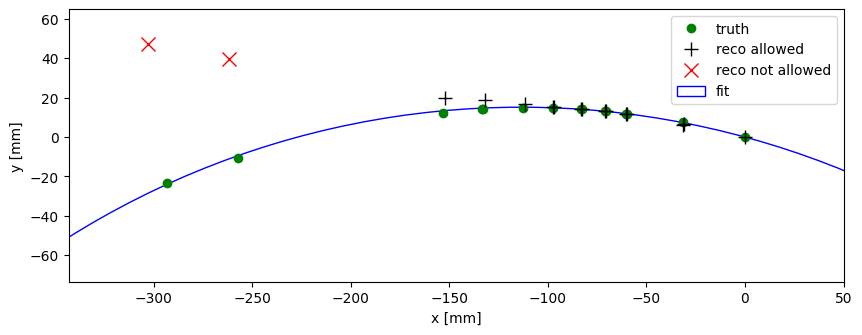

In [86]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(X, Y, 'o', color='g', label='truth')
# ax.plot(X_t, Y_t, 'x', color='r', label='test')
ax.plot(X_t[allowed], Y_t[allowed], color='black', marker='+', markersize=10, label='reco allowed', linestyle='None')
ax.plot(X_t[~allowed], Y_t[~allowed], color='red', marker='x', markersize=10, label='reco not allowed', linestyle='None')

circle = plt.Circle(center, r, fill=False, color='b', label='fit')
ax.add_patch(circle)
ax.set_xlim(X.min()-50, X.max()+50)
ax.set_ylim(Y.min()-50, Y.max() + 50)
ax.set_aspect('equal', 'box')

ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

ax.legend()

In [87]:
allowed

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True])

[-25.073142434949034, -24.9456467000702, -24.81834361251032, -24.691233234716037, -24.56431562903896, -24.437590857736836, -24.31105898297193, -24.1847200668127, -24.058574171232635, -23.93262135811051, -23.806861689230345, -23.681295226281463, -23.55592203085854, -23.43074216446132, -23.305755688494685, -23.18096266426869, -23.056363152998642, -22.93195721580463, -22.807744913712042, -22.683726307651227, -22.55990145845726, -22.436270426870692, -22.312833273536512, -22.1895900590049, -22.066540843730706, -21.943685688073742, -21.821024652298604, -21.698557796574676, -21.576285180976015, -21.45420686548141, -21.33232290997455, -21.2106333742434, -21.089138317980996, -20.96783780078448, -20.846731882156064, -20.72582062150218, -20.60510407813382, -20.48458231126665, -20.364255380020552, -20.24412334341997, -20.12418626039363, -20.004444189774745, -19.884897190300876, -19.765545320613796, -19.646388639259612, -19.52742720468865, -19.408661075255623, -19.290090309219124, -19.1717149647423

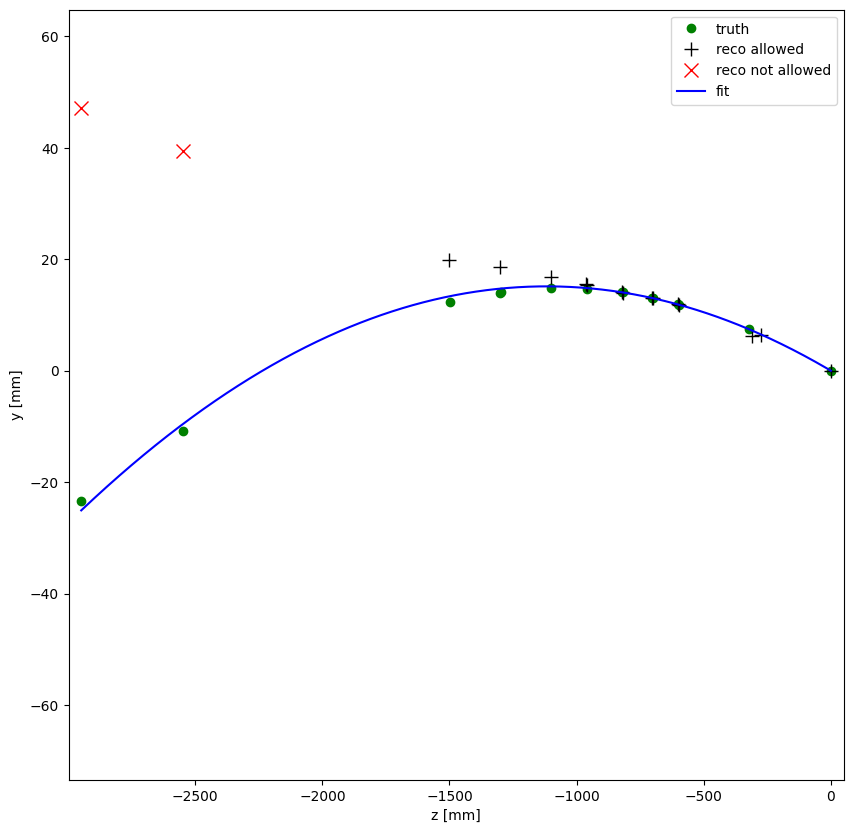

In [88]:
z_in = np.linspace(Z.min(), Z.max(), 1000)
y_out = [eq_yz(z) for z in z_in]

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(Z, Y, 'o', color='g', label='truth')
# ax.plot(Z_t, Y_t, 'x', color='r', label='test'))
ax.plot(Z_t[allowed], Y_t[allowed], color='black', marker='+', markersize=10, label='reco allowed', linestyle='None')
ax.plot(Z_t[~allowed], Y_t[~allowed], color='red', marker='x', markersize=10, label='reco not allowed', linestyle='None')
ax.plot(z_in, y_out, '-', color='b', label='fit')
ax.set_xlim(Z.min()-50, Z.max()+50)
ax.set_ylim(Y.min()-50, Y.max() + 50)

ax.set_xlabel('z [mm]')
ax.set_ylabel('y [mm]')
# ax.set_aspect('equal', 'box')

ax.legend()
print(y_out)

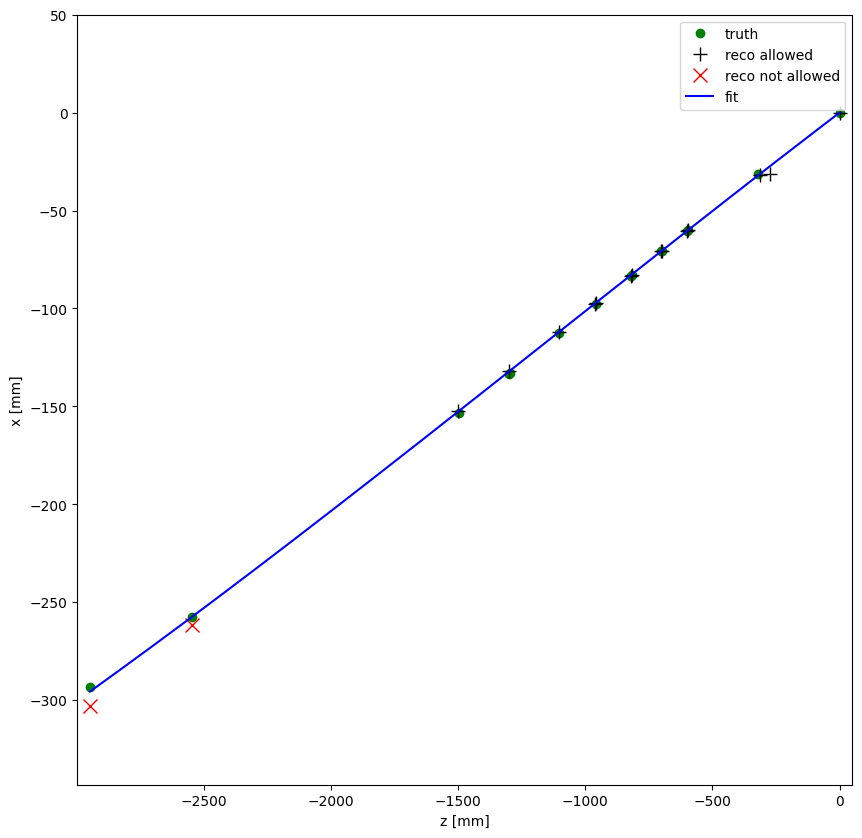

In [89]:
z_in = np.linspace(Z.min(), Z.max(), 1000)
x_out = [eq_xz(z) for z in z_in]

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(Z, X, 'o', color='g', label='truth')
# ax.plot(Z_t, X_t, 'x', color='r', label='test')
ax.plot(Z_t[allowed], X_t[allowed], color='black', marker='+', markersize=10, label='reco allowed', linestyle='None')
ax.plot(Z_t[~allowed], X_t[~allowed], color='red', marker='x', markersize=10, label='reco not allowed', linestyle='None')
ax.plot(z_in, x_out, '-', color='b', label='fit')
ax.set_xlim(Z.min()-50, Z.max()+50)
ax.set_ylim(X.min()-50, X.max() + 50)

ax.set_xlabel('z [mm]')
ax.set_ylabel('x [mm]')
# ax.set_aspect('equal', 'box')

ax.legend()

# Insert limiting function in `get_path`

In [90]:
from numpy.typing import NDArray
from typing import Callable

def validator_from_path_idx(
    path_indices: list[int], 
    hits: pd.DataFrame, 
    abs_tolerance_line: float,
    abs_tolerance_r: float,
    abs_tolerance_trig: float,
    info: bool = True,
    **kwargs
) -> Callable[[float, float, float], dict]:
    x_2, y_2, z_2 = hits.iloc[path_indices][["x", "y", "z"]].values.T  # type: ignore
    # Add origin
    x_0, y_0, z_0 = 0, 0, 0
    x_3 = np.append(x_2, x_0)
    y_3 = np.append(y_2, y_0)
    z_3 = np.append(z_2, z_0)

    # Get validator
    validator = get_validator(
        x_3,  # type: ignore
        y_3,  # type: ignore
        z_3,  # type: ignore
        abs_tolerance_line=abs_tolerance_line,
        abs_tolerance_r=abs_tolerance_r,
        abs_tolerance_trig=abs_tolerance_trig,
        verbose=False,
        info = info
    )
    
    return validator


def path_add_one(
    path_indices: list[int],
    mask: NDArray,
    a: float | NDArray,
    validator: Callable[[float, float, float], dict] | None,
    thr: float,
    module_id: NDArray,
    skip_same_module: bool = True,
    preds: list[NDArray] | None = None,
    features: NDArray | None = None,
    hits: pd.DataFrame | None = None,
    model: Model | None = None,
    fit: bool = False,
    abs_tolerance_line: float = 10,
    abs_tolerance_r: float = 10,
    abs_tolerance_trig: float = 10, 
    **kwargs
):
    # Predict probability of each pair of hits with the last hit in the path
    hit_id_last = path_indices[-1] + 1

    if preds is not None:
        p = retrieve_predict(hit_id_last, preds)
    else:
        p = make_predict(model=model, features=features, hits=hits, hit_id=hit_id_last, thr=thr) # type: ignore

    # Generate mask of hits that have a probability above the threshold
    mask = (p > thr) * mask
    # Mask last added hit
    mask[path_indices[-1]] = 0

    if skip_same_module:
        path_ids = np.array(path_indices) + 1
        mask = mask_same_module(mask, path_ids, p, thr, module_id)

    # `a` is the culuminative probability between each hit in the path
    # At each step we look at the best candidate for the whole (previously geberate) track
    a = (p + a) * mask

    # When two points are added, we can build a helix and use it to validate the next point
    if fit and validator is None and len(path_indices) == 2:
        validator = validator_from_path_idx(**locals()) # type: ignore

    # TODO
    # p_ = p + diffs(p) * weight

    # TODO
    # if validator(x,y)
    if validator:
        for i in range(100):
            cand_idx = a.argmax()
            x_t, y_t, z_t = hits.iloc[cand_idx][["x", "y", "z"]].values  # type: ignore
            validation = validator(x_t, y_t, z_t)
            print(validation)
            validated = validation["validated"]
            if not validated:
                a[cand_idx] = 0
                # mask[cand_idx] = 0
                continue
            else:
                break

    # Add index of hit with highest probability to path, proceed with this hit as the seed for the next iteration
    if a.max() > thr * len(path_indices):
        path_indices.append(a.argmax())  # type: ignore
        do_break = False
    # Breaking condition: if best average probability is below threshold, end path
    else:
        do_break = True

    return path_indices, mask, a, validator, do_break


def get_path_smart(
    hit_id: int,
    thr: float,
    mask: NDArray,
    module_id: NDArray,
    skip_same_module: bool = True,
    preds: list[NDArray] | None = None,
    features: NDArray | None = None,
    hits: pd.DataFrame | None = None,
    model: Model | None = None,
    fit = False,
    abs_tolerance_line=10,
    abs_tolerance_r=10,
    abs_tolerance_trig=10, 
):
    """Predict set of hits that belong to the same track as hit_id.
    Returns list[hit_id].
    """
    # Verify correct input
    if preds is None and (features is None or hits is None or model is None):
        raise ValueError("Either preds or features and truth must be provided")
    if fit and hits is None:
        raise ValueError("hits must be provided if fit=True")

    # Convert to index
    hit_index = hit_id - 1
    path_indices = [hit_index]
    a = 0
    
    validator = None
    while True:
        # Keep adding hits until breaking condition is met
        path_indices, mask, a, validator, do_break = path_add_one(**locals())
        if do_break:
            break
    # Convert indices back to hit_ids by adding 1
    return np.array(path_indices) + 1



In [91]:
apply_fit = True

In [92]:
path_test_idx = get_path_smart(hit_id_test, thr=PATH_THR, mask = np.ones(len(event.hits)), module_id=module_id,features= event.features, hits=event.hits, model=used_model, fit=apply_fit, abs_tolerance_line=2, abs_tolerance_r=2, abs_tolerance_trig=2) -1

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step
Validator is helix
tolerances 2 2 0
{'validated': True, 'validation_circle': {'validated': True, 'diff': 0.6161010516930787}, 'validation_trig': {'validated': True, 'validated_yz': True, 'validated_xz': True, 'validated_xyz': True, 'diff_yz': 0.6210155224211749, 'diff_xz': 0.1176215392710287, 'diff_z': 0.007216825849809538, 'diff_x': 0.11749871181663707, 'diff_y': 0.6209920840009886, 'diff_xyz': 0.6320515787859458, 'eq_yz': <function validator_trig.<locals>.<lambda> at 0x7f1b586e7130>, 'eq_xz': <function validator_trig.<locals>.<lambda> at 0x7f1b586e7250>}, 'diff': 0.6320515787859458, 'center': (-113.45292669130609, -417.6757464206158), 'r': 432.8101150884085, 'f': -0.00023730055601348565, 'f_zy': array([-0.00023728]), 'f_zx': array([-0.00023733]), 'phi_0': 1.3055666193980557, 'z_0': 0}
1/1 [==============================] - 0s 17ms/step
tolerances 2 2 0
{'validated': True, 'validation_circle': {'validated': True, 'diff': 0.0320188580

In [93]:
center, r

((-113.45292669130609, -417.6757464206158), 432.8101150884085)

In [94]:
path_test_data = event.hits.iloc[path_test_idx]
X_ts, Y_ts, Z_ts = path_test_data[['x', 'y', 'z']].values.T
X_ts = np.append(X_ts, x_0)
Y_ts = np.append(Y_ts, y_0)
Z_ts = np.append(Z_ts, z_0)
path_test_data

,hit_id,x,y,z,volume_id,layer_id,module_id
13805,13806,-60.553200,11.889400,-602.000000,7,14,104
11391,11392,-70.438599,12.991600,-697.500000,7,12,106
6502,6503,-97.122101,15.442700,-957.500000,7,8,106
8911,8912,-82.908096,14.023100,-817.500000,7,10,106
4457,4458,-111.817001,16.885099,-1102.000000,7,6,107
8863,8864,-83.382698,14.079300,-822.000000,7,10,104
6428,6429,-97.566597,15.479200,-962.000000,7,8,104
11338,11339,-70.906097,13.037900,-702.000000,7,12,104
13841,13842,-60.102100,11.827000,-597.500000,7,14,106
14137,14138,-31.638599,6.144290,-311.725006,8,2,48


2023-08-20 02:10:28 DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2023-08-20 02:10:28 DEBUG    findfont: score(FontEntry(fname='/project/atlas/users/lschoonh/miniconda/envs/myrootenv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-08-20 02:10:28 DEBUG    findfont: score(FontEntry(fname='/project/atlas/users/lschoonh/miniconda/envs/myrootenv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-08-20 02:10:28 DEBUG    findfont: score(FontEntry(fname='/project/atlas/users/lschoonh/miniconda/envs/myrootenv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', va

2023-08-20 02:10:28 DEBUG    findfont: score(FontEntry(fname='/project/atlas/users/lschoonh/miniconda/envs/myrootenv/fonts/Ubuntu-LI.ttf', name='Ubuntu', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
2023-08-20 02:10:28 DEBUG    findfont: score(FontEntry(fname='/project/atlas/users/lschoonh/miniconda/envs/myrootenv/fonts/Ubuntu-L.ttf', name='Ubuntu', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
2023-08-20 02:10:28 DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-BoldItalic.otf', name='Nimbus Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2023-08-20 02:10:28 DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/D050000L.otf', name='D050000L', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-08-20 02:10:28 DEBUG    findfont: score(FontEntry(fname='/usr/s

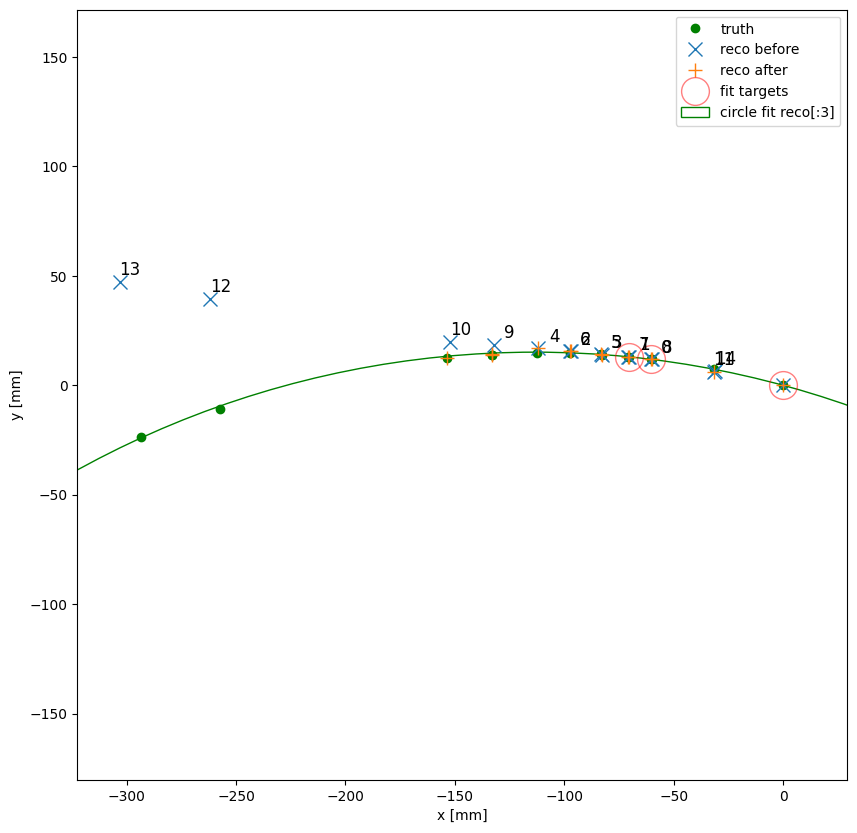

In [95]:
# fig, ax = plot_fit(X_t_3,Y_t_3,Z_t_3, *do_fit(X_t_3,Y_t_3,Z_t_3, deg=2, crop=5), 'y', label='reco[:3]', crop=5)
# ax.plot(Z,Y,'g--', label='truth', marker='x', markersize=10, alpha=0.5)
# ax.scatter(Z_t, Y_t, color='red', marker='x',label='reco', alpha= 0.2)
# ax.legend()
# ax

plt.subplots(figsize=(10,10))
plt.plot(X,Y, 'go', label='truth')
plt.plot(X_t, Y_t, 'x', label='reco before' , markersize=10)
plt.plot(X_ts, Y_ts, '+', label='reco after' , markersize=10)
plt.plot([*X_ts[:2],0],[*Y_ts[:2], 0],'o', color='r', fillstyle='none', alpha=0.5, label = 'fit targets', markersize=20)
circle = plt.Circle(center, r, fill=False, color='g', label = 'circle fit reco[:3]')
plt.gca().add_patch(circle)

for i, (x, y, z) in enumerate(zip(X_t[:-1], Y_t[:-1], Z_t[:-1])):
    plt.annotate(text=str(i), xy=(x, y), xytext =(15,5), ha='right', textcoords='offset points', fontsize=12)

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

xlim_0, ylim_0 = get_crop(X, Y, crop=crop, square=True)
xlim_1, ylim_1 = get_crop(X_ts, Y_ts, crop=crop, square=True)
xlim = (min(xlim_0[0], xlim_1[0]), max(xlim_0[1], xlim_1[1]))
ylim = (min(ylim_0[0], ylim_1[0]), max(ylim_0[1], ylim_1[1]))
plt.xlim(xlim)
plt.ylim(ylim)

# plt.gca().figure.set_size_inches(10,10)
plt.gca().set_aspect('equal', 'box')
plt.legend()

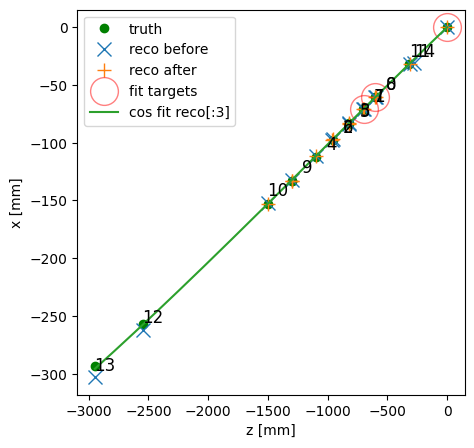

In [103]:
plt.subplots(figsize=(10,10))

plt.plot(Z,X, 'go', label = 'truth')
plt.plot(Z_t, X_t, 'x', label = 'reco before', markersize=10)
plt.plot(Z_ts, X_ts, '+', label = 'reco after', markersize=10)
plt.plot([*Z_ts[:2], 0],[*X_ts[:2],0],'o', color='r', fillstyle='none', alpha=0.5, label = 'fit targets', markersize=20)
plt.plot(z_in, [ cos_test(x, f_zx) for x in z_in], label='cos fit reco[:3]')

for i, (x, y, z) in enumerate(zip(X_t[:-1], Y_t[:-1], Z_t[:-1])):
    plt.annotate(text=str(i), xy=(z, x), xytext =(15,5), ha='right', textcoords='offset points', fontsize=12)

plt.xlabel('z [mm]')
plt.ylabel('x [mm]')
# xlim, ylim = get_crop(Z_ts, X_ts, crop=crop, square=False)
# plt.xlim(xlim)
# plt.ylim(ylim)
# plt.gca().figure.set_size_inches(10,10)
plt.legend()

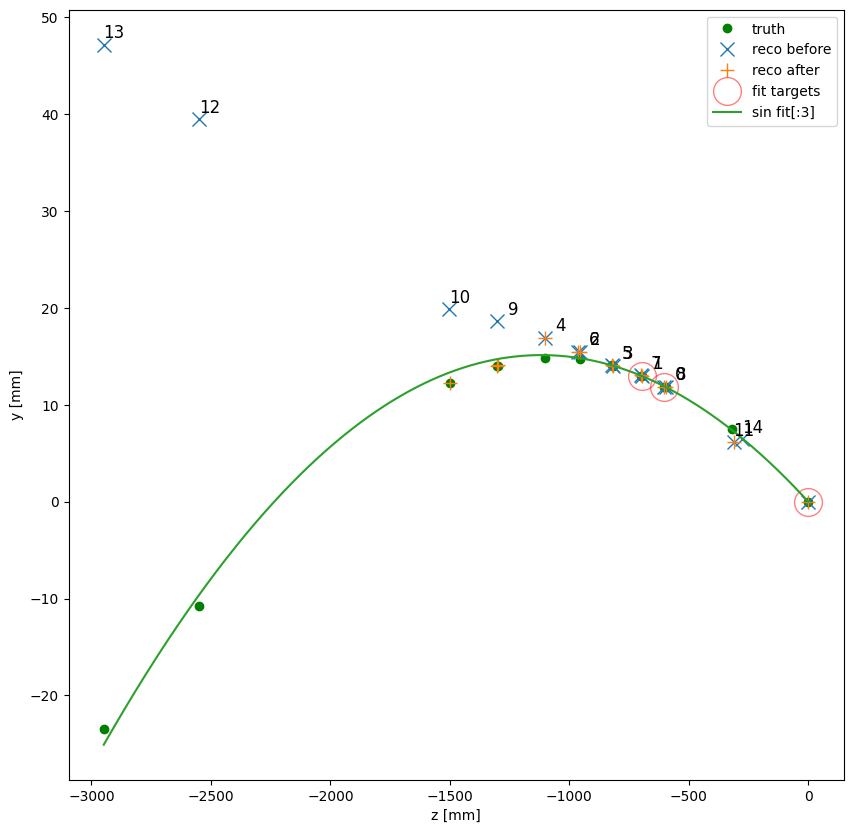

In [97]:
plt.subplots(figsize=(10,10))

plt.plot(Z,Y, 'go', label='truth')
plt.plot(Z_t, Y_t, 'x', label='reco before', markersize=10)
plt.plot(Z_ts, Y_ts, '+', label='reco after', markersize=10)
plt.plot([*Z_ts[:2], 0],[*Y_ts[:2], 0],'o', color='r', fillstyle='none', alpha=0.5, label = 'fit targets', markersize=20)
plt.plot(z_in, [ sin_test(x, f_zx) for x in z_in], label='sin fit[:3]')

for i, (x, y, z) in enumerate(zip(X_t[:-1], Y_t[:-1], Z_t[:-1])):
    plt.annotate(text=str(i), xy=(z, y), xytext =(15,5), ha='right', textcoords='offset points', fontsize=12)

plt.xlabel('z [mm]')
plt.ylabel('y [mm]')
# xlim, ylim = get_crop(Z_ts, Y_ts, crop=crop, square=False)
# plt.xlim(xlim)
# plt.ylim(ylim)
# plt.gca().figure.set_size_inches(10,10)
plt.legend()

# try (inv) attenuated sine freq; first perturbation?

In [98]:
X_att = np.linspace(0, 16000, 2000)

(0.0, 1.0)

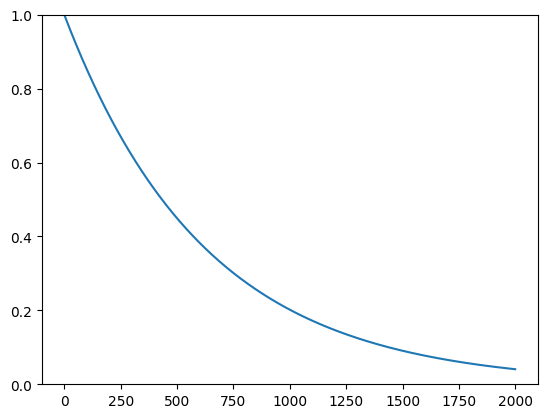

In [99]:
att = 2 / 10 ** 4
attfunc = lambda x: np.exp(-x* att)
plt.plot(np.exp(-X_att* att))
plt.ylim(0,1)

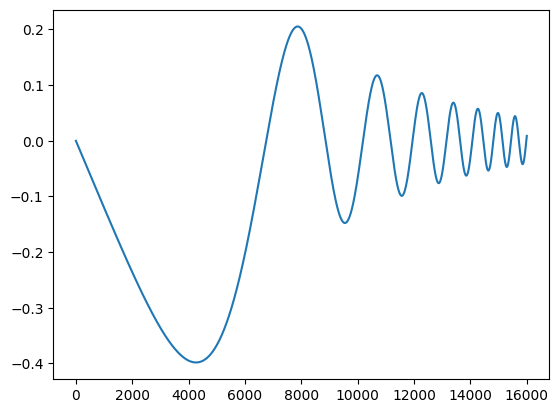

In [100]:
plt.plot(X_att, np.sin(X_att * f * 4 / attfunc(X_att))* attfunc(X_att), label='Signal')